In [2]:
# Paso 1: Importación de bibliotecas
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import kendalltau, pointbiserialr

# Integración de Weka (segura)
try:
    import weka.core.jvm as jvm
    from weka.core.converters import Loader
    from weka.classifiers import Classifier, Evaluation
    from weka.core.classes import Random
    weka_available = True
except:
    weka_available = False

# Integración de R (segura)
"""
try:
    import rpy2.robjects as ro
    from rpy2.robjects import pandas2ri
    pandas2ri.activate()
    r_available = True
except:
    r_available = False
"""


'\ntry:\n    import rpy2.robjects as ro\n    from rpy2.robjects import pandas2ri\n    pandas2ri.activate()\n    r_available = True\nexcept:\n    r_available = False\n'

In [3]:
def calcular_specificity_multiclase(y_true, y_pred):
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    specificity_scores = []

    for i in range(len(mcm)):
        tn = mcm[i][0, 0]
        fp = mcm[i][0, 1]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
        specificity_scores.append(specificity)

    return specificity_scores, np.nanmean(specificity_scores)


In [4]:
# Paso 2: Carga de datos y preprocesamiento
archivo = "weatherHistory_10.csv"
df = pd.read_csv(archivo)

# Paso 2: Preprocesamiento
# Seleccionar solo las clases más frecuentes
top_classes = df['Summary'].value_counts()[df['Summary'].value_counts() >= 50].index.tolist()
df = df[df['Summary'].isin(top_classes)].copy()

# Codificar variable objetivo
df['target'] = df['Summary'].astype('category').cat.codes

# Eliminar columnas no relevantes
df.drop(['Formatted Date', 'Summary', 'Daily Summary'], axis=1, inplace=True)

# Convertir variables a numéricas
X = df.drop('target', axis=1)
y = df['target']

# Separar en entrenamiento y validación
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

#Paso 3 convertir target a numerico 

df['target'] = df['target'].astype('category').cat.codes

# One-hot y división
y = df['target']
X = pd.get_dummies(df.drop('target', axis=1), drop_first=True).astype('float64')

c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [09:37:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of 

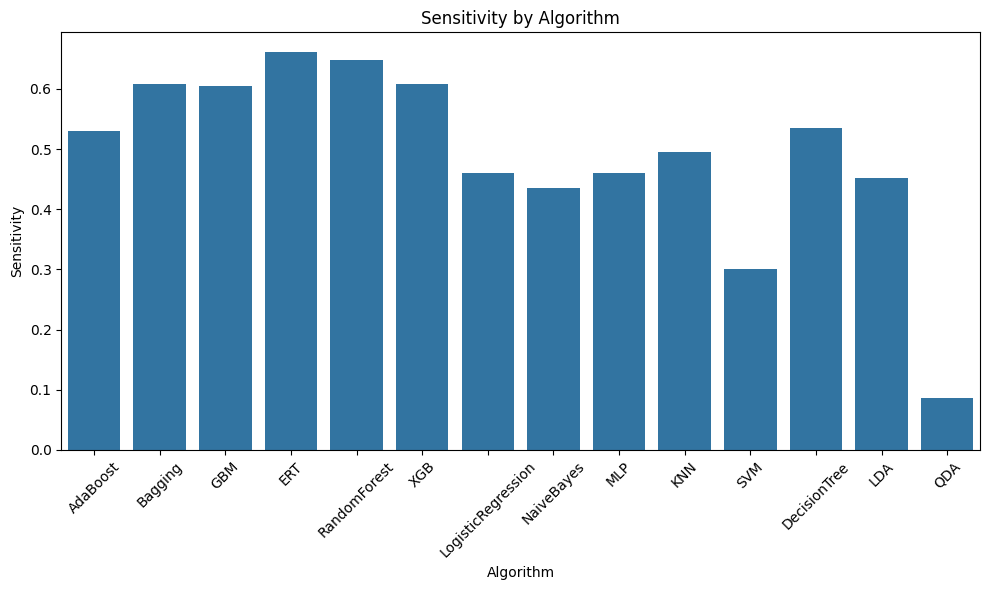

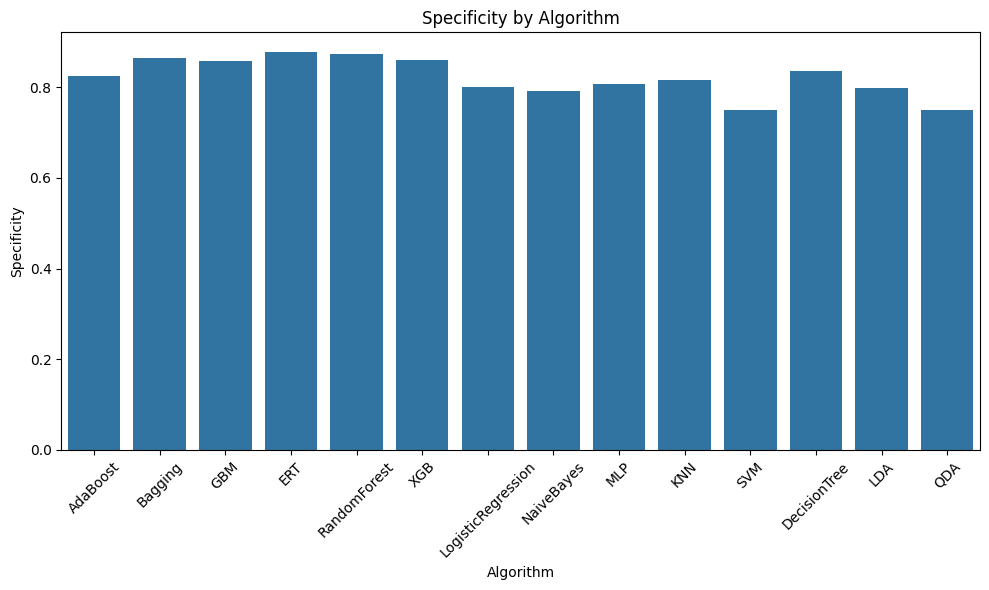

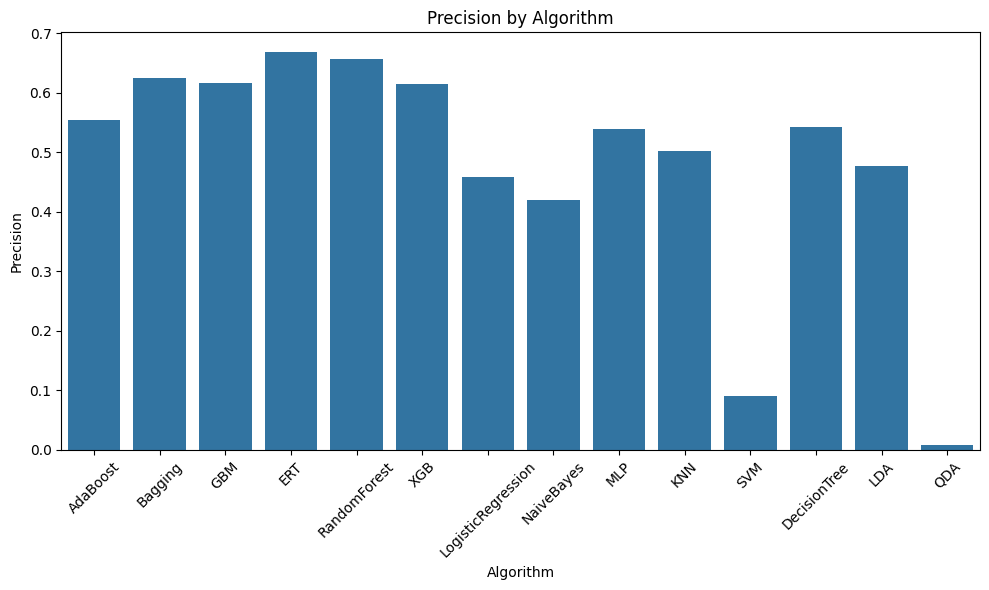

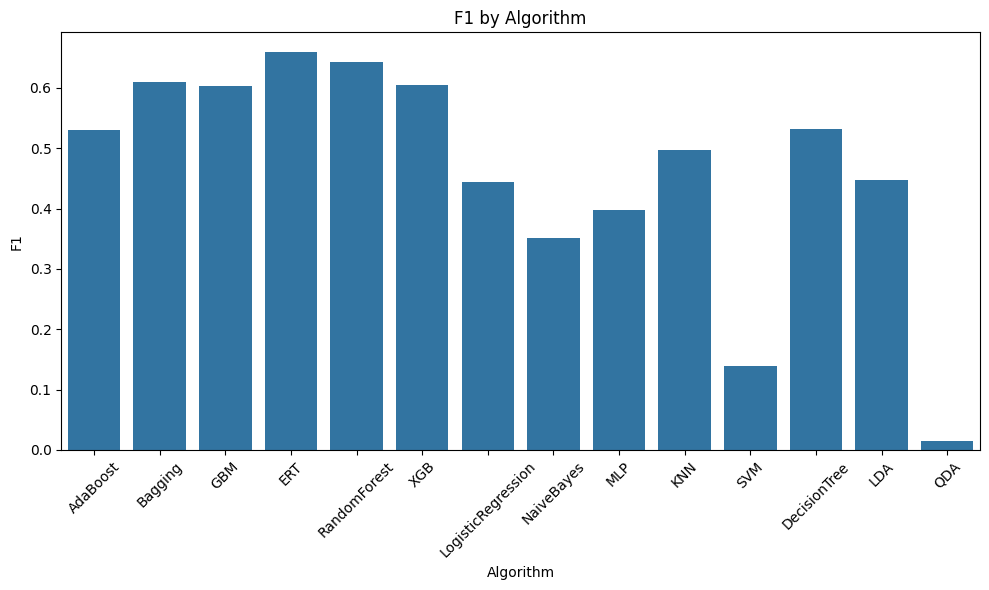

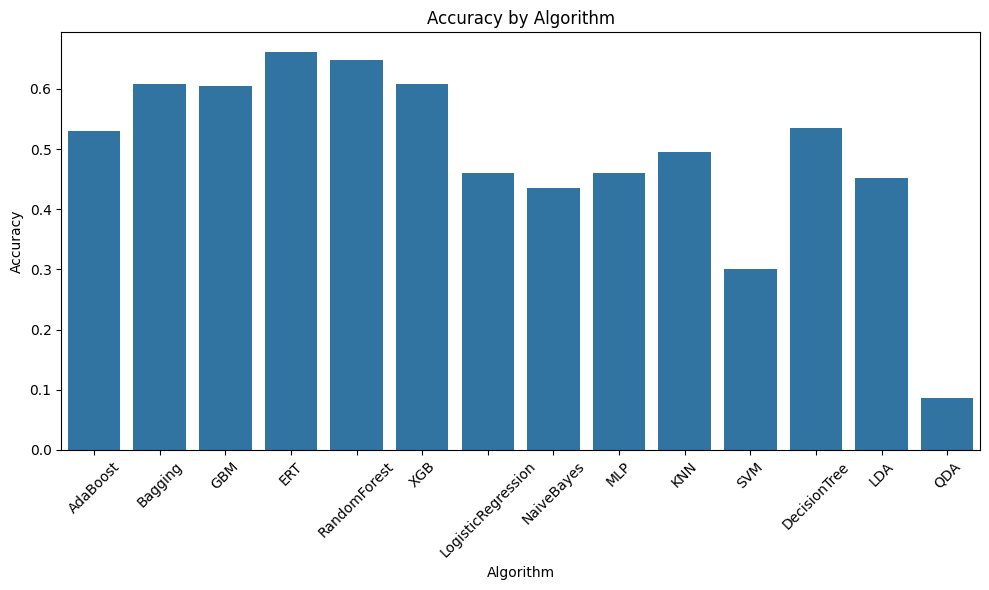

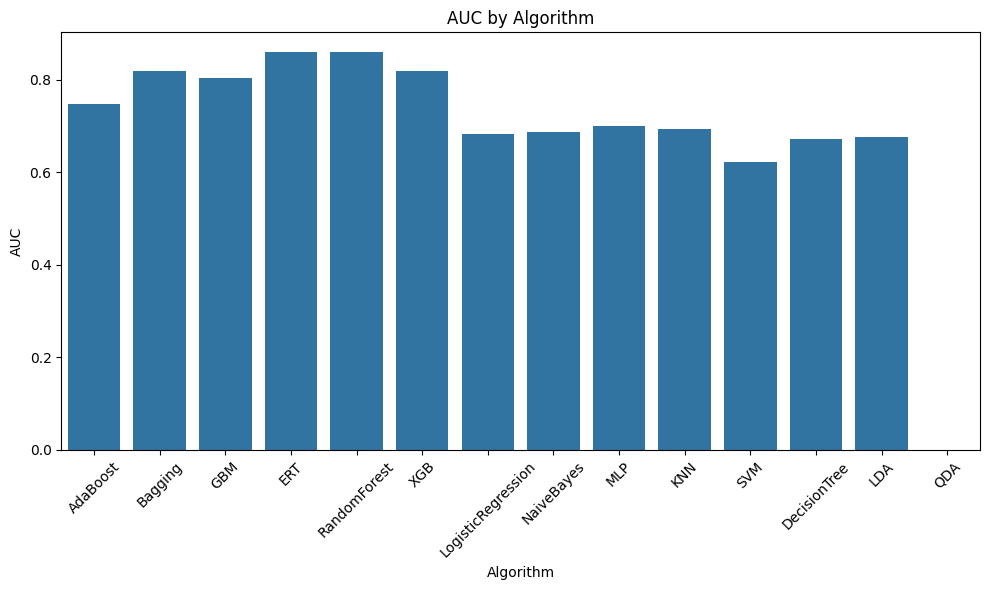

In [5]:

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

# Función actualizada para multiclase
def metricas(model, model_label, X_train, X_valid, y_train, y_valid):
    y_pred = model.predict(X_valid)

    # AUC multiclase
    try:
        y_pred_prob = model.predict_proba(X_valid)
        auc = roc_auc_score(y_valid, y_pred_prob, multi_class='ovr', average='weighted')
    except (AttributeError, ValueError):
        auc = np.nan

    cm = confusion_matrix(y_valid, y_pred)
    sensitivity = recall_score(y_valid, y_pred, average='weighted')  # Recall promedio ponderado
    specificity_list, specificity_avg = calcular_specificity_multiclase(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_valid, y_pred, average='weighted')
    accuracy = accuracy_score(y_valid, y_pred)

    return {
        'Algorithm': model_label,
        'Sensitivity': sensitivity,
        'Specificity': specificity_avg,
        'Precision': precision,
        'F1': f1,
        'Accuracy': accuracy,
        'AUC': auc
    }

# Paso 5: Modelos
models = {
    'AdaBoost': AdaBoostClassifier(),
    'Bagging': BaggingClassifier(),
    'GBM': GradientBoostingClassifier(),
    'ERT': ExtraTreesClassifier(),
    'RandomForest': RandomForestClassifier(),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'NaiveBayes': GaussianNB(),
    'MLP': MLPClassifier(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'DecisionTree': DecisionTreeClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis()
}

# Entrenar modelos
results = []
X_train_np = np.ascontiguousarray(X_train.values)
X_valid_np = np.ascontiguousarray(X_valid.values)

for model_label, model in models.items():
    model.fit(X_train_np, y_train)
    result = metricas(model, model_label, X_train_np, X_valid_np, y_train, y_valid)
    results.append(result)

df_results = pd.DataFrame(results)

# Paso 6: Visualización
metrics = ['Sensitivity', 'Specificity', 'Precision', 'F1', 'Accuracy', 'AUC']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Algorithm', y=metric, data=df_results)
    plt.title(f'{metric} by Algorithm')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    


In [6]:
 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, cohen_kappa_score
)
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

le_repeated = LabelEncoder()
y_encoded = le_repeated.fit_transform(y)

def repeated_cv_metrics(model, X, y, n_repeats=10, n_splits=4, seed_base=42):
    metrics = {
        'accuracy': [], 'precision': [], 'recall': [], 'specificity': [],
        'f1': [], 'auc': [], 'mcc': [], 'kappa': []
    }
    
    for i in range(n_repeats):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed_base + i)
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
           # y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

            cm = confusion_matrix(y_test, y_pred)
            if cm.shape == (2, 2):
                tn, fp, fn, tp = cm.ravel()
                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            else:
                specificities = []
                for j in range(cm.shape[0]):
                    tn = cm.sum() - (cm[j, :].sum() + cm[:, j].sum() - cm[j, j])
                    fp = cm[:, j].sum() - cm[j, j]
                    specificity_i = tn / (tn + fp) if (tn + fp) > 0 else 0
                    specificities.append(specificity_i)
                specificity = np.mean(specificities)

            metrics['accuracy'].append(accuracy_score(y_test, y_pred))
            metrics['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
            metrics['recall'].append(recall_score(y_test, y_pred, average='macro'))
            metrics['specificity'].append(specificity)
            metrics['f1'].append(f1_score(y_test, y_pred, average='macro'))
          
            if y_proba is not None and not np.isnan(y_proba).any():
                try:
                    auc_score = roc_auc_score(y_test, y_proba, multi_class='ovr')
                except ValueError:
                    auc_score = np.nan
            else:
                auc_score = np.nan
            metrics['auc'].append(auc_score)
            
            metrics['mcc'].append(matthews_corrcoef(y_test, y_pred))
            metrics['kappa'].append(cohen_kappa_score(y_test, y_pred))
    return pd.DataFrame(metrics)

 

'''
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, cohen_kappa_score, confusion_matrix
)
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd

def repeated_cv_metrics(model, X, y, n_repeats=10, n_splits=4, seed_base=42):
    all_metrics = []

    for i in range(n_repeats):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed_base + i)

        for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

            cm = confusion_matrix(y_test, y_pred)
            if cm.shape == (2, 2):
                tn, fp, fn, tp = cm.ravel()
                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            else:
                specificities = []
                for j in range(cm.shape[0]):
                    tn = cm.sum() - (cm[j, :].sum() + cm[:, j].sum() - cm[j, j])
                    fp = cm[:, j].sum() - cm[j, j]
                    specificity_i = tn / (tn + fp) if (tn + fp) > 0 else 0
                    specificities.append(specificity_i)
                specificity = np.mean(specificities)

            # Calcular AUC de forma segura
            if y_proba is not None and not np.isnan(y_proba).any():
                try:
                    auc_score = roc_auc_score(y_test, y_proba, multi_class='ovr')
                except ValueError:
                    auc_score = np.nan
            else:
                auc_score = np.nan

            all_metrics.append({
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
                'recall': recall_score(y_test, y_pred, average='macro'),
                'specificity': specificity,
                'f1': f1_score(y_test, y_pred, average='macro'),
                'auc': auc_score,
                'mcc': matthews_corrcoef(y_test, y_pred),
                'kappa': cohen_kappa_score(y_test, y_pred),
                'repeat': i,
                'fold': fold
            })

    return pd.DataFrame(all_metrics)

'''    


'\nfrom sklearn.metrics import (\n    accuracy_score, precision_score, recall_score, f1_score,\n    roc_auc_score, matthews_corrcoef, cohen_kappa_score, confusion_matrix\n)\nfrom sklearn.model_selection import StratifiedKFold\nimport numpy as np\nimport pandas as pd\n\ndef repeated_cv_metrics(model, X, y, n_repeats=10, n_splits=4, seed_base=42):\n    all_metrics = []\n\n    for i in range(n_repeats):\n        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed_base + i)\n\n        for fold, (train_index, test_index) in enumerate(skf.split(X, y)):\n            X_train, X_test = X.iloc[train_index], X.iloc[test_index]\n            y_train, y_test = y[train_index], y[test_index]\n\n            model.fit(X_train, y_train)\n            y_pred = model.predict(X_test)\n            y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None\n\n            cm = confusion_matrix(y_test, y_pred)\n            if cm.shape == (2, 2):\n                tn, f

In [7]:
# Evaluación con validación cruzada repetida
resultados_repetidos = {}

for model_label, model in models.items():
    print(f"Evaluando (repetido): {model_label}") 
    df_metrics = repeated_cv_metrics(model, X, y_encoded, n_repeats=10, n_splits=4)
    df_metrics["modelo"] = model_label
    resultados_repetidos[model_label] = df_metrics

df_resultados_repetidos = pd.concat(resultados_repetidos.values(), ignore_index=True)

Evaluando (repetido): AdaBoost
Evaluando (repetido): Bagging
Evaluando (repetido): GBM
Evaluando (repetido): ERT
Evaluando (repetido): RandomForest
Evaluando (repetido): XGB


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [09:38:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [09:38:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [09:38:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [09:38:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

Evaluando (repetido): LogisticRegression


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Evaluando (repetido): NaiveBayes
Evaluando (repetido): MLP
Evaluando (repetido): KNN
Evaluando (repetido): SVM
Evaluando (repetido): DecisionTree
Evaluando (repetido): LDA
Evaluando (repetido): QDA


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is not full rank. Increasing the value of param

In [8]:
# Tabla resumen por modelo con media y desviación estándar
resumen_repetido = df_resultados_repetidos.groupby("modelo").agg(['mean', 'std']).round(4)
display(resumen_repetido)

accuracy         precision          recall          \
                       mean     std      mean     std    mean     std   
modelo                                                                  
AdaBoost             0.5086  0.0338    0.5431  0.0535  0.4706  0.0363   
Bagging              0.6170  0.0343    0.6253  0.0433  0.5932  0.0370   
DecisionTree         0.5658  0.0330    0.5535  0.0408  0.5517  0.0397   
ERT                  0.6493  0.0355    0.6716  0.0481  0.6111  0.0384   
GBM                  0.6008  0.0320    0.6290  0.0401  0.5772  0.0343   
KNN                  0.5028  0.0300    0.4868  0.0439  0.4533  0.0324   
LDA                  0.4462  0.0320    0.4266  0.0801  0.3611  0.0266   
LogisticRegression   0.4505  0.0285    0.4291  0.0923  0.3600  0.0224   
MLP                  0.4266  0.0390    0.4220  0.1108  0.3575  0.0488   
NaiveBayes           0.4185  0.0336    0.4345  0.1408  0.3818  0.0396   
QDA                  0.1401  0.1065    0.0350  0.0266  0.2500  0.0000   
RandomForest         0.6411  0.0293    0.6617  0.0406  0.6041  0.0315   
SVM                  0.4201  0.0240    0.2105  0.0259  0.2867  0.0162   
XGB                  0.6280  0.0288    0.6489  0.0373  0.6051  0.0346   

                   specificity              f1             auc          \
                          mean     std    mean     std    mean     std   
modelo                                                                   
AdaBoost                0.8136  0.0132  0.4899  0.0372  0.7515  0.0181   
Bagging                 0.8569  0.0125  0.6035  0.0369  0.8209  0.0207   
DecisionTree            0.8408  0.0118  0.5497  0.0392  0.6962  0.0255   
ERT                     0.8674  0.0134  0.6305  0.0398  0.8595  0.0194   
GBM                     0.8494  0.0121  0.5953  0.0349  0.8218  0.0200   
KNN                     0.8147  0.0105  0.4629  0.0360  0.7178  0.0259   
LDA                     0.7890  0.0125  0.3614  0.0268  0.6894  0.0243   
LogisticRegression      0.7892  0.0110  0.3595  0.0238  0.6831  0.0262   
MLP                     0.7859  0.0155  0.3197  0.0726  0.6824  0.0258   
NaiveBayes              0.7891  0.0111  0.3005  0.0493  0.7133  0.0235   
QDA                     0.7500  0.0000  0.0582  0.0358     NaN     NaN   
RandomForest            0.8647  0.0110  0.6226  0.0328  0.8579  0.0178   
SVM                     0.7713  0.0094  0.2406  0.0218  0.6165  0.0310   
XGB                     0.8599  0.0109  0.6200  0.0341  0.8391  0.0178   

                       mcc           kappa          
                      mean     std    mean     std  
modelo                                              
AdaBoost            0.2739  0.0513  0.2702  0.0517  
Bagging             0.4425  0.0496  0.4405  0.0492  
DecisionTree        0.3739  0.0472  0.3730  0.0473  
ERT                 0.4860  0.0524  0.4840  0.0523  
GBM                 0.4151  0.0471  0.4134  0.0470  
KNN                 0.2712  0.0424  0.2684  0.0420  
LDA                 0.1671  0.0498  0.1645  0.0492  
LogisticRegression  0.1696  0.0442  0.1662  0.0434  
MLP                 0.1769  0.0572  0.1489  0.0620  
NaiveBayes          0.1966  0.0489  0.1643  0.0453  
QDA                 0.0000  0.0000  0.0000  0.0000  
RandomForest        0.4744  0.0430  0.4725  0.0432  
SVM                 0.0921  0.0406  0.0851  0.0375  
XGB                 0.4566  0.0423  0.4550  0.0422

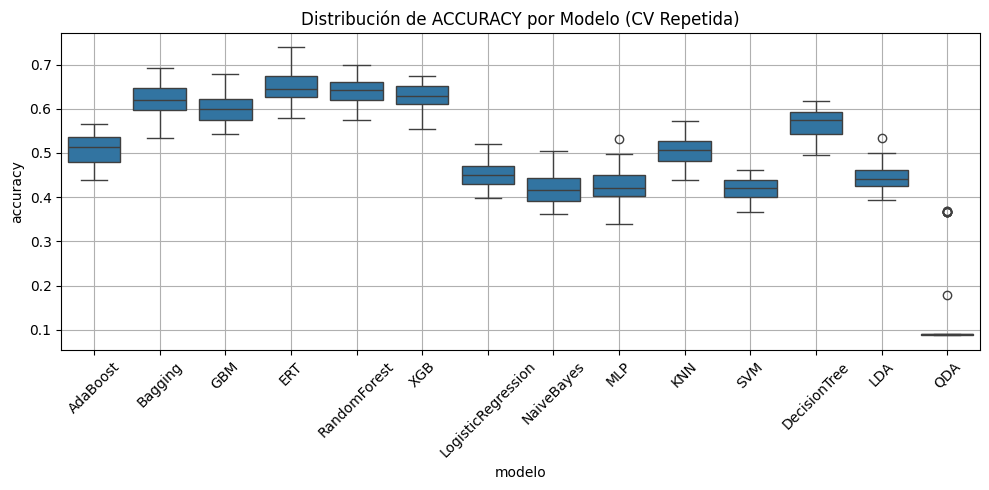

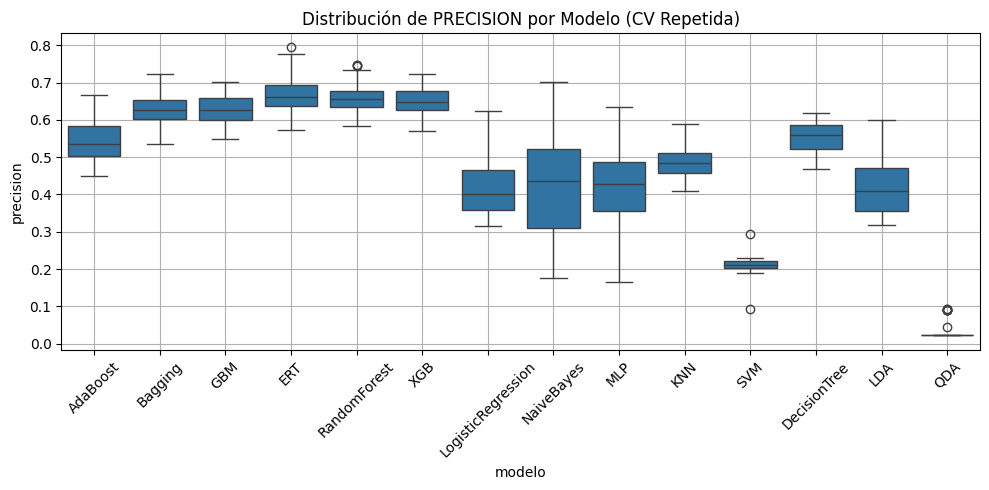

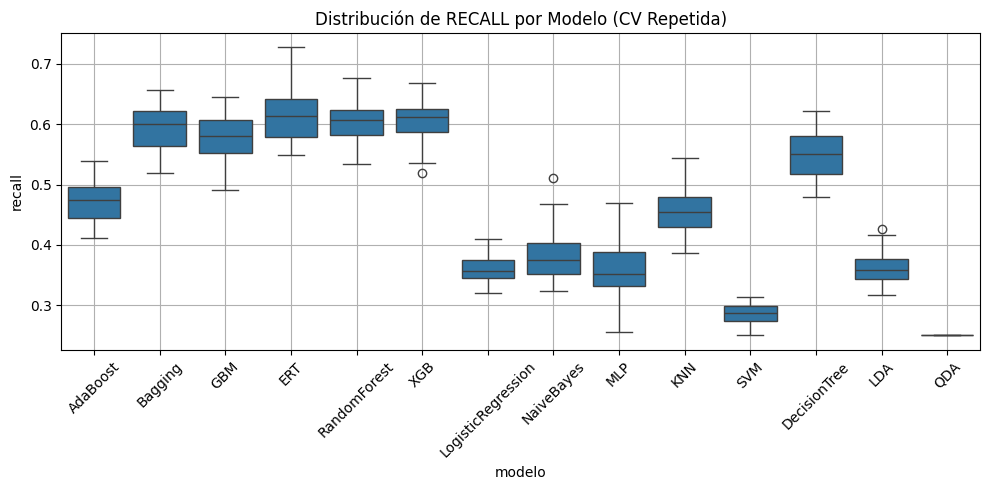

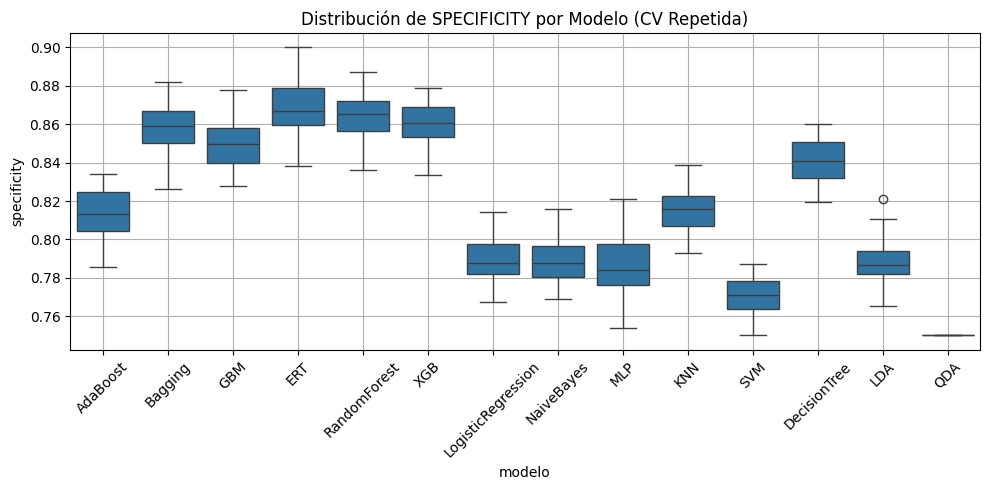

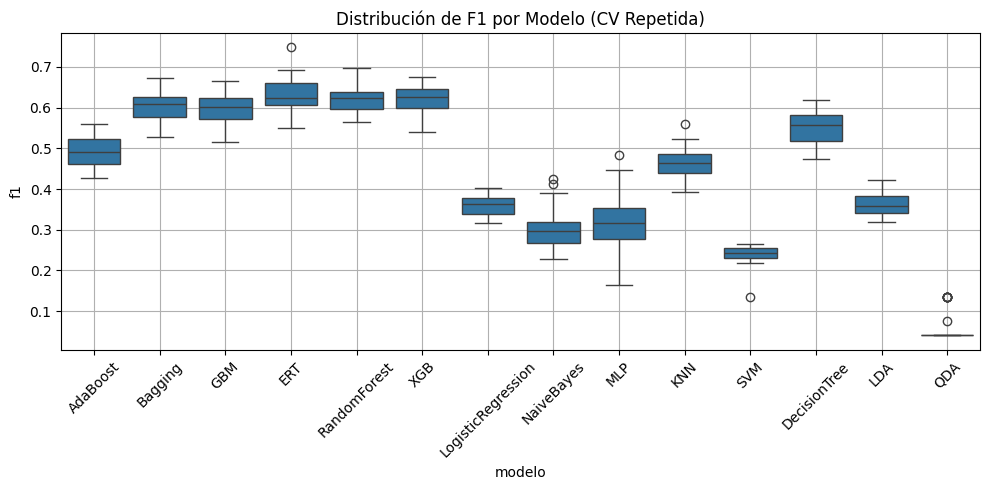

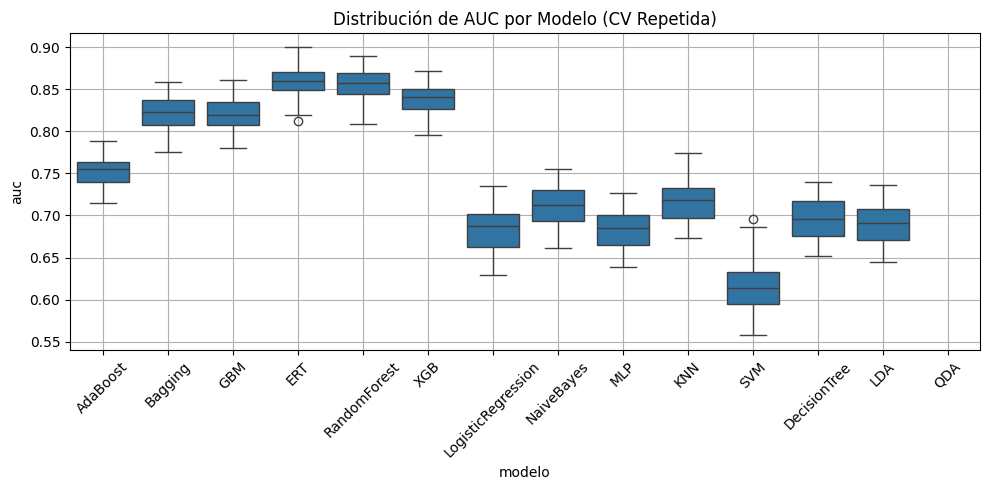

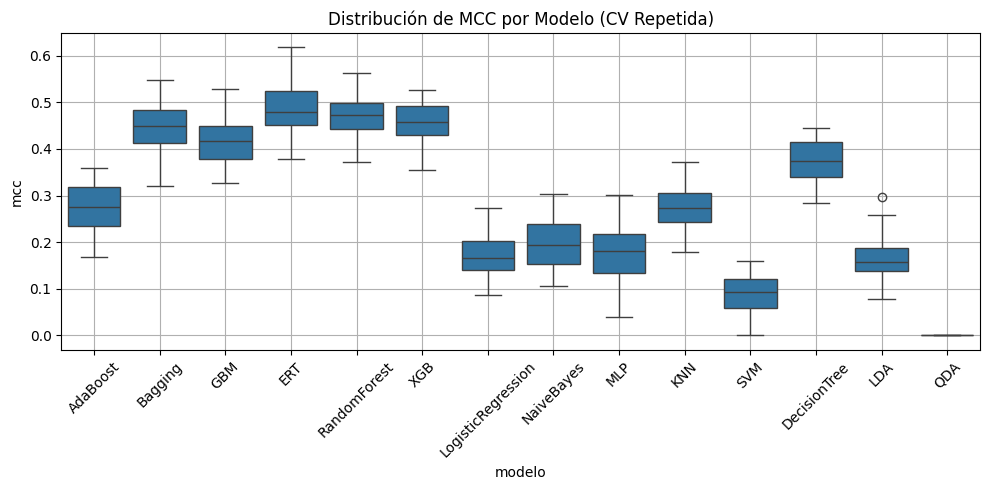

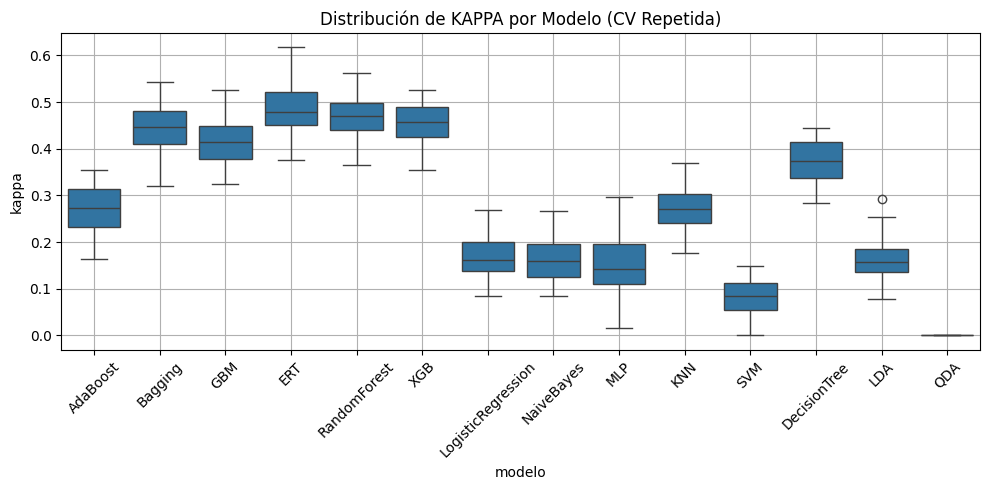

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

metricas_a_graficar = ['accuracy', 'precision', 'recall', 'specificity', 'f1', 'auc', 'mcc', 'kappa']

for metrica in metricas_a_graficar:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df_resultados_repetidos, x="modelo", y=metrica)
    plt.title(f"Distribución de {metrica.upper()} por Modelo (CV Repetida)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\scipy\stats\_stats_py.py:5405: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


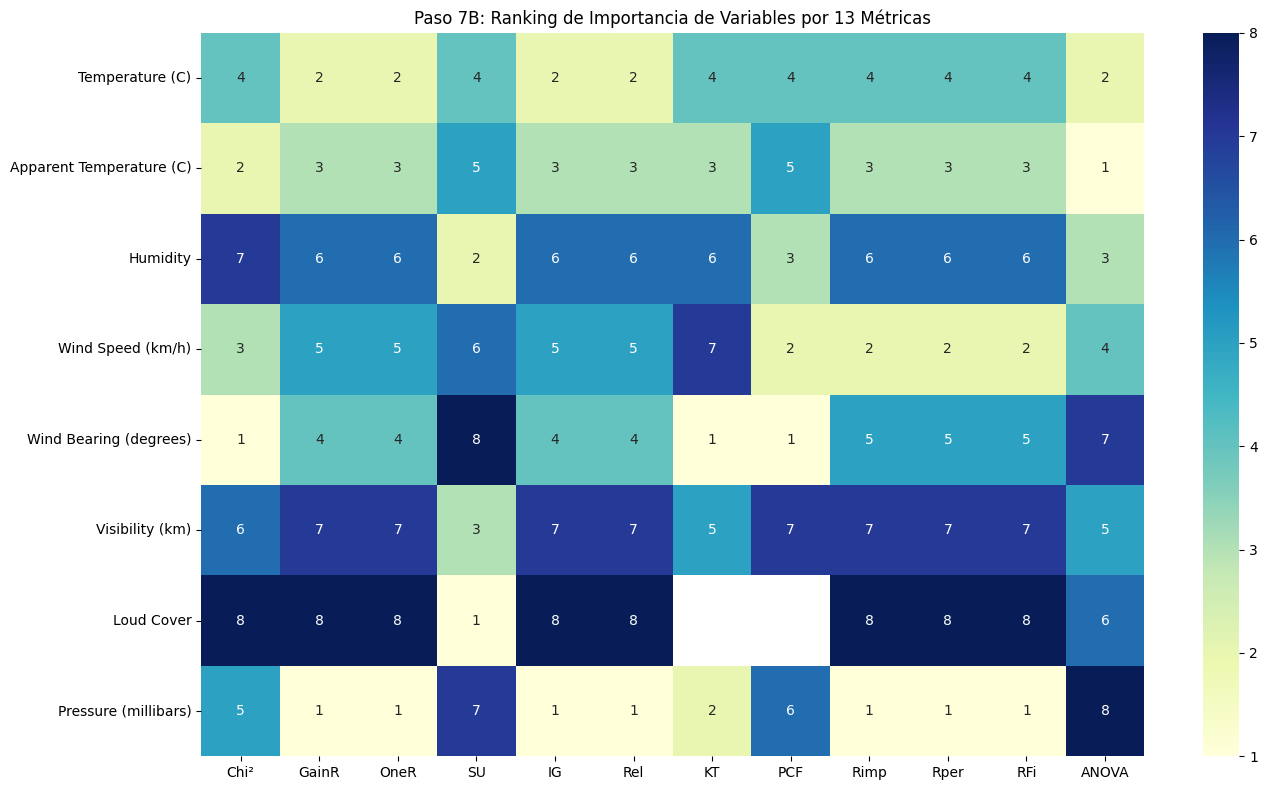

                          Chi²  GainR  OneR   SU   IG  Rel   KT  PCF  Rimp  \
Pressure (millibars)       5.0    1.0   1.0  7.0  1.0  1.0  2.0  6.0   1.0   
Apparent Temperature (C)   2.0    3.0   3.0  5.0  3.0  3.0  3.0  5.0   3.0   
Temperature (C)            4.0    2.0   2.0  4.0  2.0  2.0  4.0  4.0   4.0   
Wind Speed (km/h)          3.0    5.0   5.0  6.0  5.0  5.0  7.0  2.0   2.0   
Wind Bearing (degrees)     1.0    4.0   4.0  8.0  4.0  4.0  1.0  1.0   5.0   
Humidity                   7.0    6.0   6.0  2.0  6.0  6.0  6.0  3.0   6.0   
Visibility (km)            6.0    7.0   7.0  3.0  7.0  7.0  5.0  7.0   7.0   
Loud Cover                 8.0    8.0   8.0  1.0  8.0  8.0  NaN  NaN   8.0   

                          Rper  RFi  ANOVA      Mean  Rank  
Pressure (millibars)       1.0  1.0    8.0  2.916667   1.0  
Apparent Temperature (C)   3.0  3.0    1.0  3.083333   2.0  
Temperature (C)            4.0  4.0    2.0  3.166667   3.0  
Wind Speed (km/h)          2.0  2.0    4.0  4.000000 

In [10]:
''' # Paso 7: Importancia de las características

# Preparar datos desde el dataset ya procesado (X, y)
df_importancia = X.copy()
df_importancia['target'] = y

# Asegurar que todos los valores sean positivos para chi2
X_imp = df_importancia.drop('target', axis=1).apply(lambda col: col - col.min() + 1e-6)
y_imp = df_importancia['target']

# Métricas base
chi2_vals, _ = chi2(X_imp, y_imp)
mi_vals = mutual_info_classif(X_imp, y_imp)
anova_vals, _ = f_classif(X_imp, y_imp)

# Random Forest Importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_imp, y_imp)
rfi_vals = rf.feature_importances_

# AUC por variable multiclase
auc_vals = []
for col in X_imp.columns:
    try:
        auc = roc_auc_score(y_imp, X_imp[col], multi_class='ovr', average='macro')
    except:
        auc = np.nan
    auc_vals.append(auc)

# Kendall Tau
kt_vals = [abs(kendalltau(X_imp[col], y_imp).correlation) for col in X_imp.columns]

# PCF (punto biserial)
pcf_vals = [abs(pointbiserialr(X_imp[col], y_imp)[0]) for col in X_imp.columns]

# Aproximaciones para GainR, OneR, SU, Rel, Rimp, Rper
# Utilizamos MI como proxy, SU se normaliza por varianza
gainr_vals = mi_vals
oner_vals = mi_vals
su_vals = mi_vals / (X_imp.var().values + 1e-6)
rel_vals = mi_vals
rimp_vals = rfi_vals
rper_vals = rfi_vals

# Compilar en DataFrame
importancia_df = pd.DataFrame({
    'Chi²': chi2_vals,
    'GainR': gainr_vals,
    'OneR': oner_vals,
    'SU': su_vals,
    'IG': mi_vals,
    'Rel': rel_vals,
    'KT': kt_vals,
    'PCF': pcf_vals,
    'Rimp': rimp_vals,
    'Rper': rper_vals,
    'RFi': rfi_vals,
    'AUC': auc_vals,
    'ANOVA': anova_vals
}, index=X_imp.columns)

#Paso 7B: Cálculo de 13 métricas de importancia y ranking final
# Calcular rankings
ranking_df = importancia_df.rank(ascending=False)
ranking_df['Mean'] = ranking_df.mean(axis=1)
ranking_df['Rank'] = ranking_df['Mean'].rank()

# Exportar a CSV (puedes personalizar la ruta)
ranking_df.sort_values("Rank").to_csv("ranking_importancia_metricas.csv")

# Visualización
plt.figure(figsize=(14, 8))
sns.heatmap(ranking_df.iloc[:, :-2], annot=True, cmap='YlGnBu')
plt.title("Paso 7B: Ranking de Importancia de Variables por 13 Métricas")
plt.tight_layout()
plt.show()

# Mostrar tabla ordenada por importancia
print(ranking_df.sort_values("Rank"))
'''
# --- Codificación y preparación numérica ---
df_encoded = df.copy()
df_encoded['target'] = df['target']  # Ya codificado numéricamente

X_encoded = pd.get_dummies(df_encoded.drop(columns=['target']), drop_first=True).astype('float64')
df_encoded = X_encoded.copy()
df_encoded['target'] = df['target']

# --- Paso 7: Importancia de características ---
X_imp = df_encoded.drop('target', axis=1).apply(lambda col: col - col.min() + 1e-6)
y_imp = df_encoded['target']

# Métricas de importancia
chi2_vals, _ = chi2(X_imp, y_imp)
mi_vals = mutual_info_classif(X_imp, y_imp)
anova_vals, _ = f_classif(X_imp, y_imp)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_imp, y_imp)
rfi_vals = rf.feature_importances_

# Otros indicadores
kt_vals = [abs(kendalltau(X_imp[col], y_imp).correlation) for col in X_imp.columns]
pcf_vals = [abs(pointbiserialr(X_imp[col], y_imp)[0]) for col in X_imp.columns]
su_vals = mi_vals / (X_imp.var().values + 1e-6)

# Compilar DataFrame de métricas de importancia
importancia_df = pd.DataFrame({
    'Chi²': chi2_vals,
    'GainR': mi_vals,
    'OneR': mi_vals,
    'SU': su_vals,
    'IG': mi_vals,
    'Rel': mi_vals,
    'KT': kt_vals,
    'PCF': pcf_vals,
    'Rimp': rfi_vals,
    'Rper': rfi_vals,
    'RFi': rfi_vals,
    'ANOVA': anova_vals
}, index=X_imp.columns)

# Ranking final
ranking_df = importancia_df.rank(ascending=False)
ranking_df['Mean'] = ranking_df.mean(axis=1)
ranking_df['Rank'] = ranking_df['Mean'].rank()

# Exportar a CSV (puedes personalizar la ruta)
ranking_df.sort_values("Rank").to_csv("ranking_importancia_metricas.csv")

# Visualización
plt.figure(figsize=(14, 8))
sns.heatmap(ranking_df.iloc[:, :-2], annot=True, cmap='YlGnBu')
plt.title("Paso 7B: Ranking de Importancia de Variables por 13 Métricas")
plt.tight_layout()
plt.show()

# Mostrar tabla ordenada por importancia
print(ranking_df.sort_values("Rank"))

C:\Users\americasys\AppData\Local\Temp\ipykernel_436\818342429.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_plot, x=col, hue='target', fill=False)


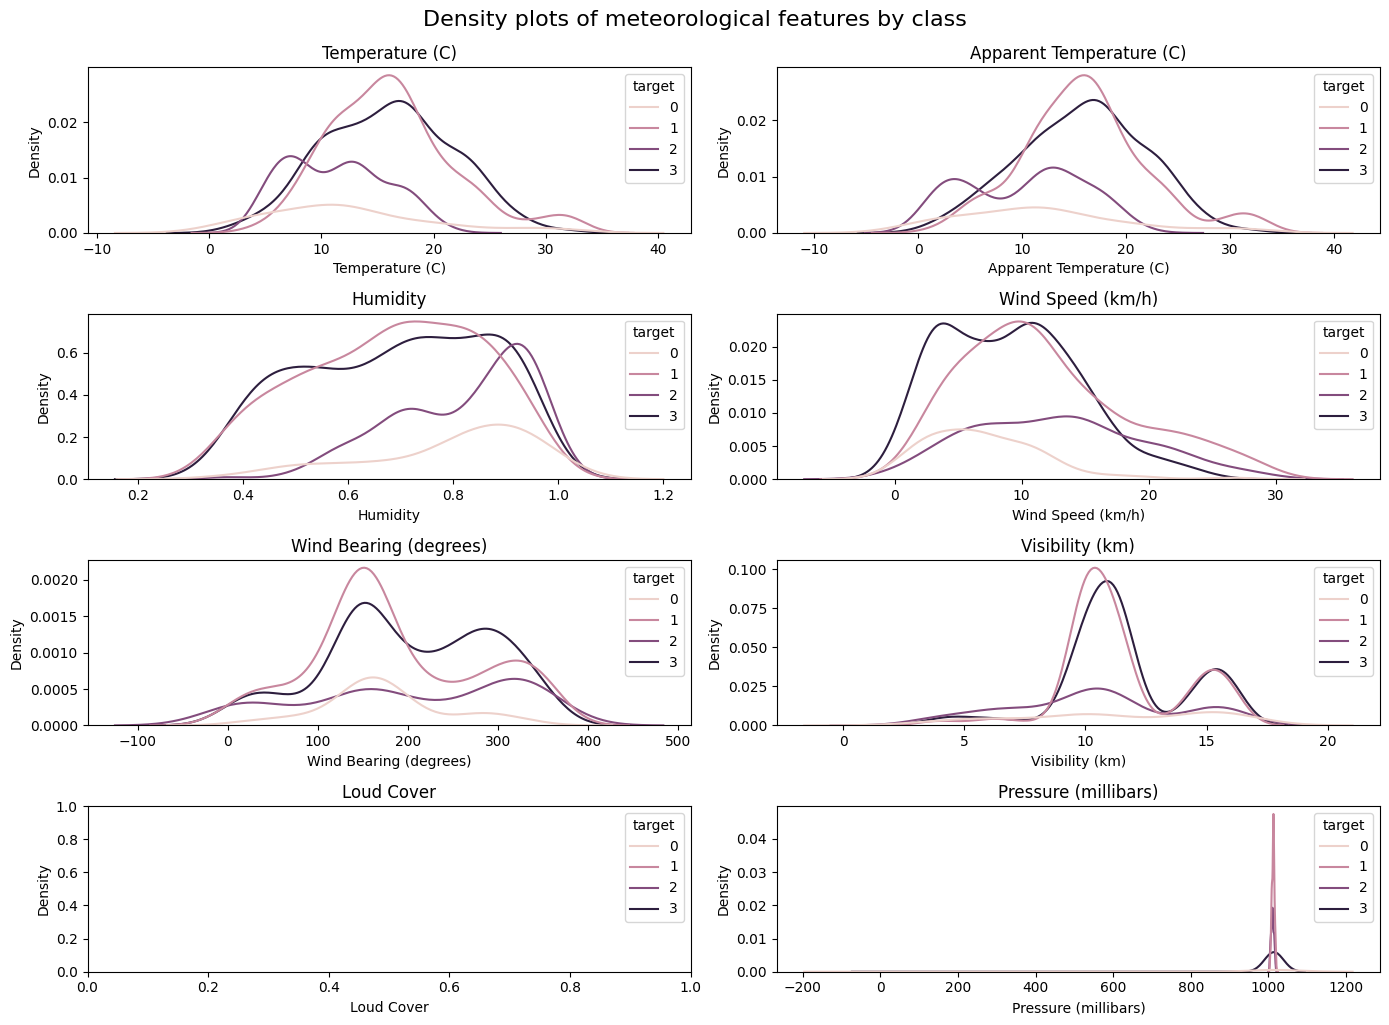

In [11]:
# Paso 7C: Gráficos de densidad de variables numéricas por clase

numerical_features = X.columns.tolist()
df_plot = X.copy()
df_plot['target'] = y

plt.figure(figsize=(14, 10))
for i, col in enumerate(numerical_features, 1):
    plt.subplot((len(numerical_features) + 1) // 2, 2, i)
    sns.kdeplot(data=df_plot, x=col, hue='target', fill=False)
    plt.title(col)

plt.tight_layout()
plt.suptitle("Density plots of meteorological features by class", fontsize=16, y=1.02)
plt.show()


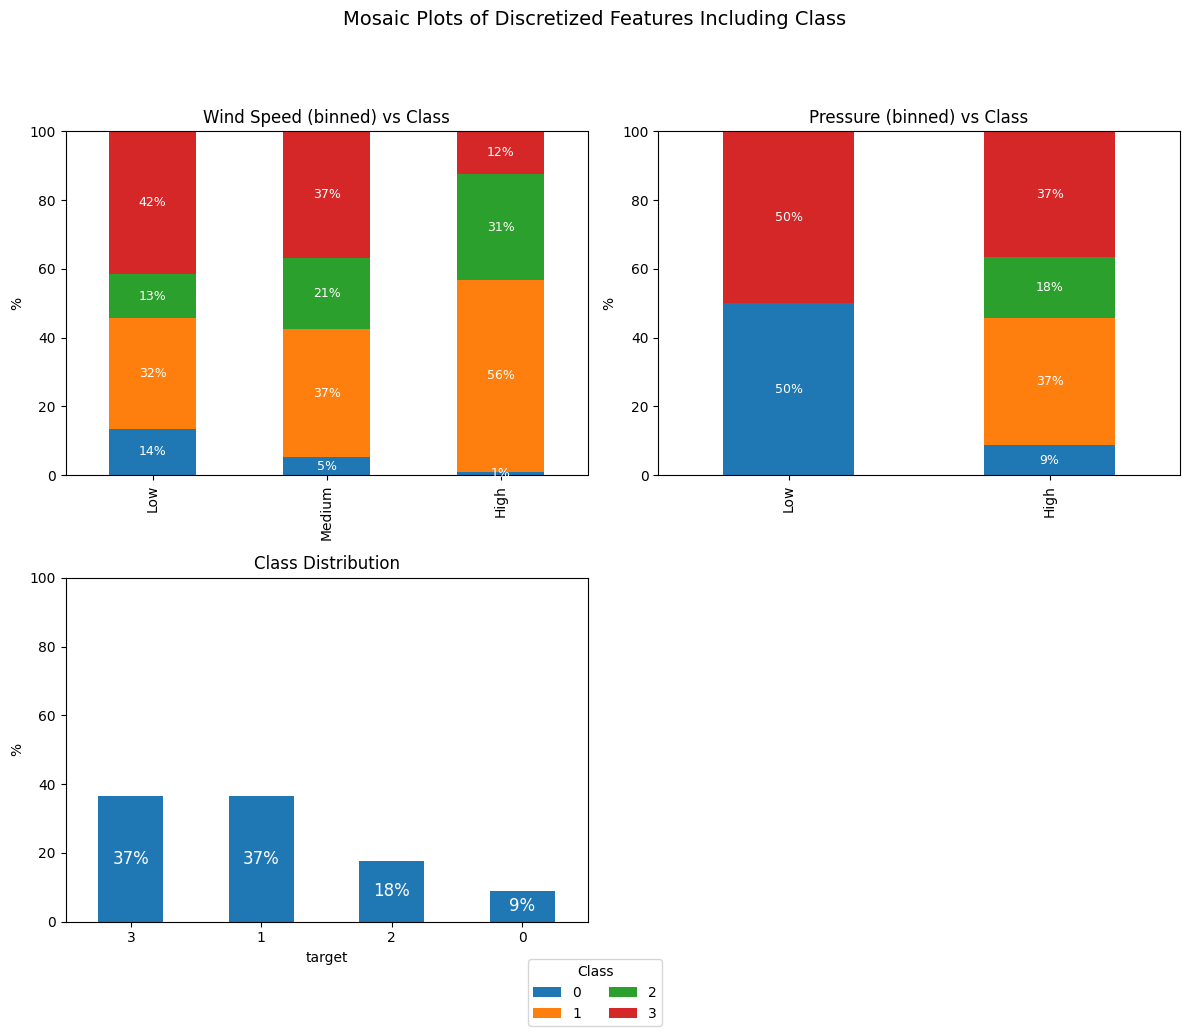

In [12]:
# Paso 7D: Gráficos de mosaico para variables categóricas incluyendo Class

# Crear copia de los datos
mosaic_df = X.copy()
mosaic_df['target'] = y

# Discretizar dos variables continuas para visualización como categóricas
mosaic_df['Wind Speed (binned)'] = pd.cut(mosaic_df['Wind Speed (km/h)'], bins=3, labels=["Low", "Medium", "High"])
mosaic_df['Pressure (binned)'] = pd.cut(mosaic_df['Pressure (millibars)'], bins=3, labels=["Low", "Medium", "High"])

categorical_cols = ['Wind Speed (binned)', 'Pressure (binned)', 'target']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    if col != 'target':
        prop_df = pd.crosstab(mosaic_df[col], mosaic_df['target'], normalize='index') * 100
        prop_df.plot(kind='bar', stacked=True, ax=ax, legend=False)
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                ax.text(p.get_x() + p.get_width() / 2., p.get_y() + height / 2.,
                        f'{height:.0f}%', ha="center", va="center", color='white', fontsize=9)
        ax.set_title(f"{col} vs Class")
        ax.set_ylabel('%')
        ax.set_xlabel('')
        ax.set_ylim(0, 100)
    else:
        class_counts = mosaic_df['target'].value_counts(normalize=True) * 100
        class_counts.plot(kind='bar', ax=ax)
        for j, v in enumerate(class_counts):
            ax.text(j, v / 2, f'{v:.0f}%', ha='center', va='center', color='white', fontsize=12)
        ax.set_title("Class Distribution")
        ax.set_ylabel('%')
        ax.set_xticklabels(class_counts.index, rotation=0)
        ax.set_ylim(0, 100)

# Eliminar subplots sobrantes si hay menos de 4 gráficos
for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Class", loc='lower center', ncol=2)
plt.suptitle('Mosaic Plots of Discretized Features Including Class', fontsize=14, y=1.02)
plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.show()



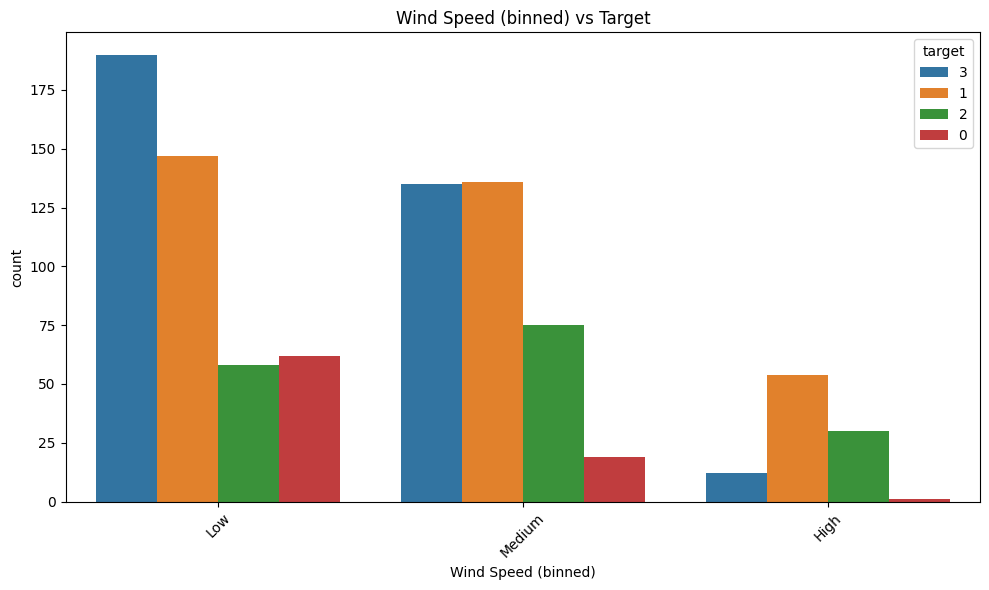

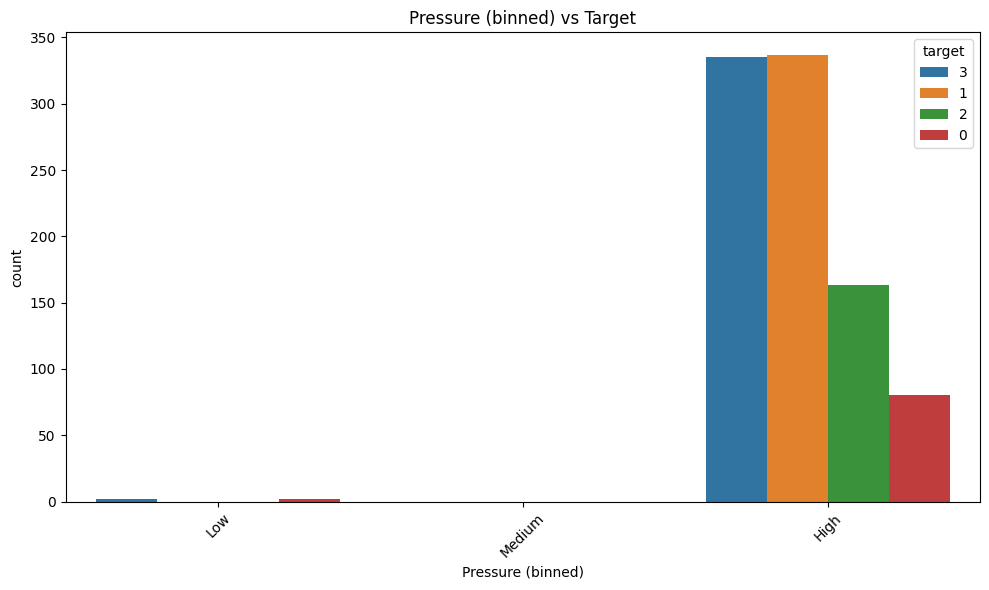

In [13]:
# Paso 8: Gráficos de variables pvs target 
# Convertir target a string para fines visuales
df_plot = X.copy()
df_plot['target'] = y.astype(str)

# Seleccionar variables discretizadas o categóricas generadas previamente
# Si ya tienes columnas discretizadas como en el paso 7D, puedes agregarlas aquí
df_plot['Wind Speed (binned)'] = pd.cut(X['Wind Speed (km/h)'], bins=3, labels=["Low", "Medium", "High"])
df_plot['Pressure (binned)'] = pd.cut(X['Pressure (millibars)'], bins=3, labels=["Low", "Medium", "High"])

categorical_columns = ['Wind Speed (binned)', 'Pressure (binned)']

for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue='target', data=df_plot)
    plt.title(f'{col} vs Target')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



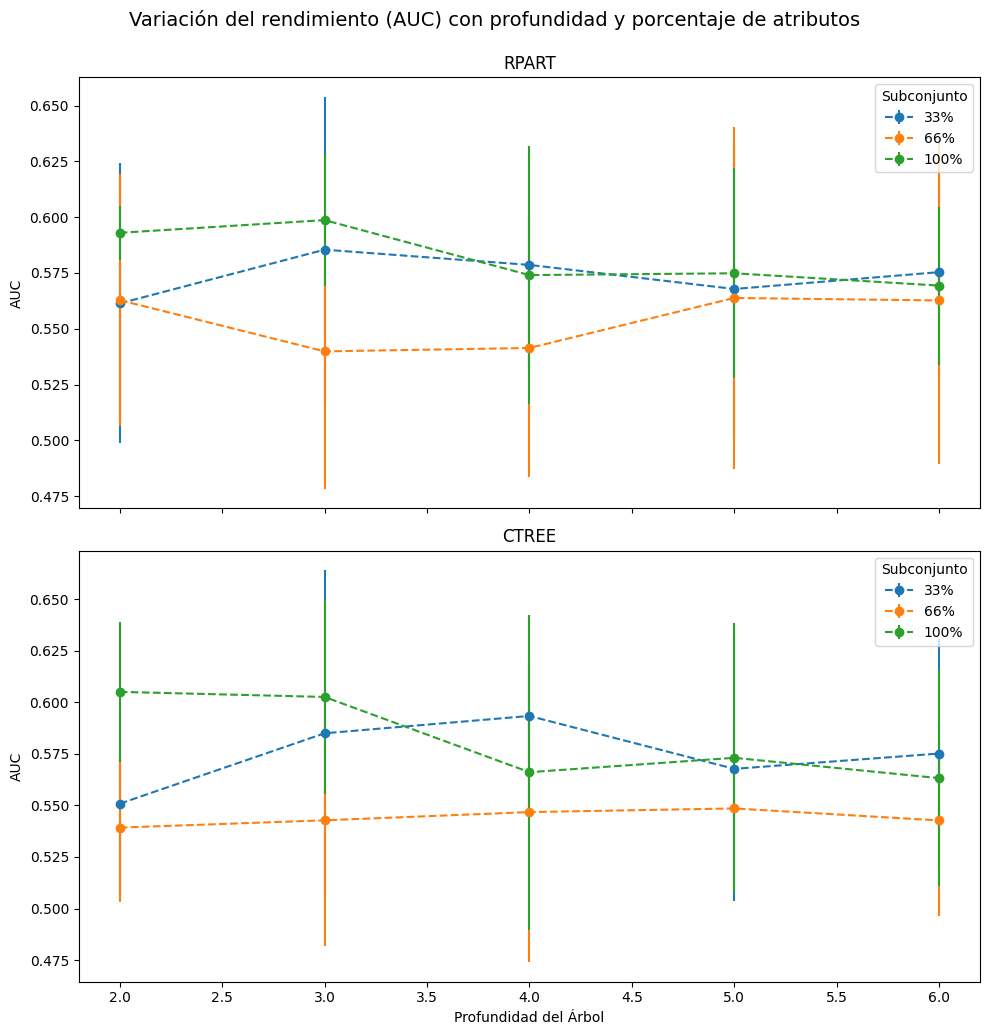

In [14]:
#paso 8.1: rendimiento (AUC) con profundidad y porcentaje de atributos
# Subconjuntos definidos
# Definición de subconjuntos de atributos
cols = X.columns.tolist()

subset_33 = cols[:max(1, len(cols)//3)]
subset_66 = cols[:max(1, 2*len(cols)//3)]
subset_100 = cols

attribute_sets = {
    '33%': subset_33,
    '66%': subset_66,
    '100%': subset_100
}

depths = [2, 3, 4, 5, 6]
results_rpart = []
results_ctree = []

for name, subset_cols in attribute_sets.items():
    X_subset = X[subset_cols]

    for depth in depths:
        # RPART (criterio Gini)
        rpart = DecisionTreeClassifier(max_depth=depth, criterion='gini', random_state=42)
        rpart_scores = cross_val_score(rpart, X_subset, y, cv=5, scoring='roc_auc_ovr_weighted')
        results_rpart.append({
            'Subset': name,
            'Depth': depth,
            'AUC': np.mean(rpart_scores),
            'Std': np.std(rpart_scores)
        })

        # CTREE (criterio Entropía)
        ctree = DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=42)
        ctree_scores = cross_val_score(ctree, X_subset, y, cv=5, scoring='roc_auc_ovr_weighted')
        results_ctree.append({
            'Subset': name,
            'Depth': depth,
            'AUC': np.mean(ctree_scores),
            'Std': np.std(ctree_scores)
        })

rpart_df = pd.DataFrame(results_rpart)
ctree_df = pd.DataFrame(results_ctree)

# Gráfica comparativa
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

for subset in rpart_df['Subset'].unique():
    data = rpart_df[rpart_df['Subset'] == subset]
    axes[0].errorbar(data['Depth'], data['AUC'], yerr=data['Std'], label=subset,
                     linestyle='dashed', marker='o')
axes[0].set_title("RPART")
axes[0].set_ylabel("AUC")
axes[0].legend(title="Subconjunto")

for subset in ctree_df['Subset'].unique():
    data = ctree_df[ctree_df['Subset'] == subset]
    axes[1].errorbar(data['Depth'], data['AUC'], yerr=data['Std'], label=subset,
                     linestyle='dashed', marker='o')
axes[1].set_title("CTREE")
axes[1].set_xlabel("Profundidad del Árbol")
axes[1].set_ylabel("AUC")
axes[1].legend(title="Subconjunto")

plt.tight_layout()
plt.suptitle("Variación del rendimiento (AUC) con profundidad y porcentaje de atributos", fontsize=14, y=1.03)
plt.show()


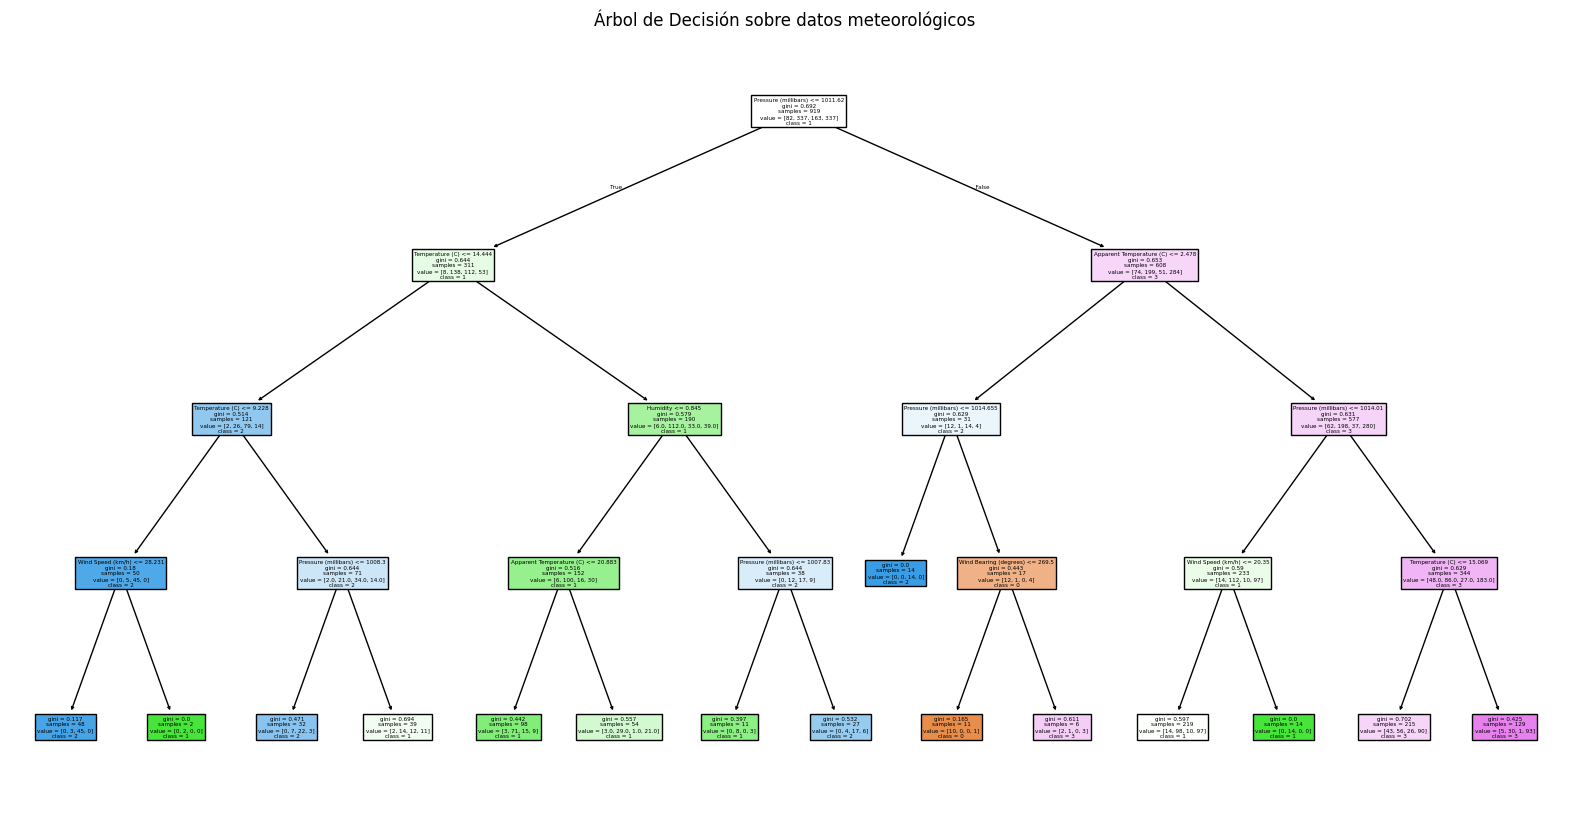

In [15]:
# Paso 9: Árbol de decisión
# Entrenar árbol con todos los datos
dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X, y)

# Obtener nombres de clases reales
class_labels = y.astype('category').cat.categories.astype(str).tolist()

# Visualización del árbol
plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=list(X.columns), class_names=class_labels)
plt.title("Árbol de Decisión sobre datos meteorológicos")
plt.show()


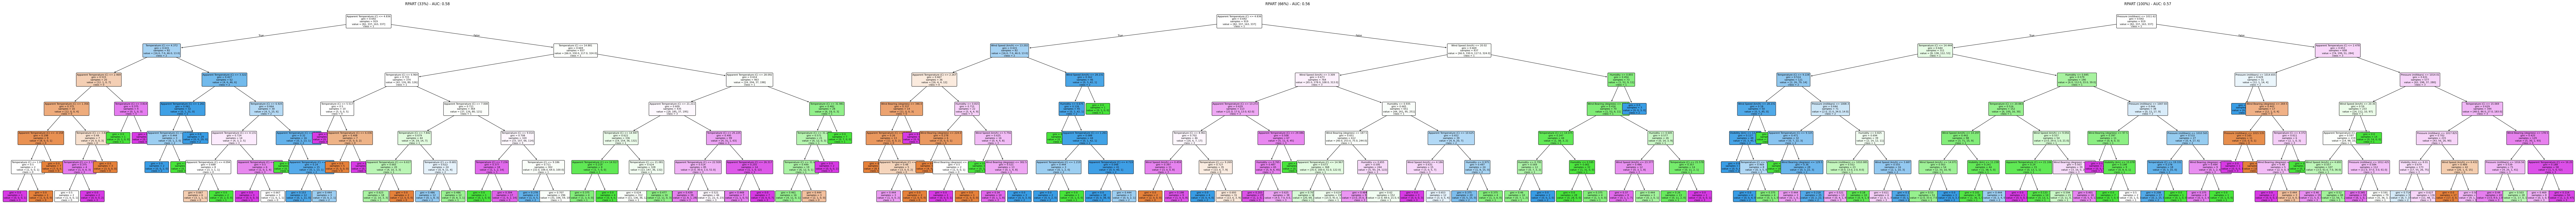

In [34]:
#Paso 9.1 Visualización de RPART con 33%, 66% y 100% de características (max_depth=6)

from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score

# Definir subconjuntos de atributos
df_vis_arbol = X.copy()
df_vis_arbol['target'] = y

subset_33 = X.columns[:max(1, len(X.columns)//3)].tolist()
subset_66 = X.columns[:max(1, 2*len(X.columns)//3)].tolist()
subset_100 = X.columns.tolist()

attribute_sets = {
    '33%': subset_33,
    '66%': subset_66,
    '100%': subset_100
}

fig, axes = plt.subplots(1, 3, figsize=(120, 10))
rpart_auc_scores = {}

for ax, (name, subset_cols) in zip(axes, attribute_sets.items()):
    X_subset = X[subset_cols]
    y_subset = y

    model = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
    model.fit(X_subset, y_subset)

    auc = cross_val_score(model, X_subset, y_subset, cv=5, scoring='roc_auc_ovr_weighted').mean()
    rpart_auc_scores[name] = auc

    plot_tree(
        model,
        feature_names=list(X_subset.columns),
        class_names=y_subset.astype('category').cat.categories.astype(str).tolist(),
        filled=True,
        rounded=True,
        fontsize=8,
        ax=ax
    )
    ax.set_title(f"RPART ({name}) - AUC: {auc:.2f}")

plt.tight_layout()
plt.show()


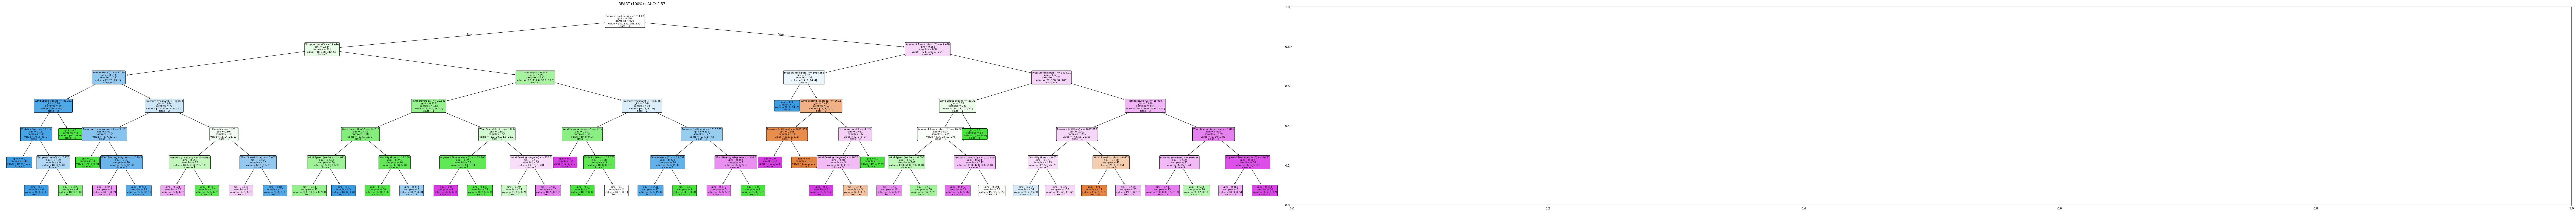

In [33]:
#Paso 9.1 Visualización de RPART con 100% de características (max_depth=6)

from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score

# Definir subconjuntos de atributos
df_vis_arbol = X.copy()
df_vis_arbol['target'] = y

subset_100 = X.columns.tolist()

attribute_sets = {
    '100%': subset_100
}

fig, axes = plt.subplots(1, 2, figsize=(120, 10))
rpart_auc_scores = {}

for ax, (name, subset_cols) in zip(axes, attribute_sets.items()):
    X_subset = X[subset_cols]
    y_subset = y

    model = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
    model.fit(X_subset, y_subset)

    auc = cross_val_score(model, X_subset, y_subset, cv=5, scoring='roc_auc_ovr_weighted').mean()
    rpart_auc_scores[name] = auc

    plot_tree(
        model,
        feature_names=list(X_subset.columns),
        class_names=y_subset.astype('category').cat.categories.astype(str).tolist(),
        filled=True,
        rounded=True,
        fontsize=8,
        ax=ax
    )
    ax.set_title(f"RPART ({name}) - AUC: {auc:.2f}")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# Preparar subconjunto 33% para visualización
subset_33 = X.columns[:max(1, len(X.columns)//3)].tolist()
X_33 = X[subset_33]
y_33 = y

# Entrenar modelo
model_33 = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
model_33.fit(X_33, y_33)

# Exportar a formato DOT
dot_data_33 = export_graphviz(
    model_33,
    out_file=None,
    feature_names=X_33.columns,
    class_names=y_33.astype('category').cat.categories.astype(str).tolist(),
    filled=True,
    rounded=True,
    special_characters=True
)

# Generar y exportar gráfico
graph_33 = graphviz.Source(dot_data_33)
graph_33.render("tree_33", format="png", cleanup=False)  # Exporta como PNG
graph_33.view()

'tree_33.pdf'

In [ ]:
# 66%
subset_66 = X.columns[:max(1, 2*len(X.columns)//3)].tolist()
X_66 = X[subset_66]
y_66 = y

# Entrenar modelo
model_66 = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
model_66.fit(X_66, y_66)

# Exportar a formato DOT
dot_data_66 = export_graphviz(
    model_66,
    out_file=None,
    feature_names=X_66.columns,
    class_names=y_66.astype('category').cat.categories.astype(str).tolist(),
    filled=True,
    rounded=True,
    special_characters=True
)

# Generar y exportar gráfico
graph_66 = graphviz.Source(dot_data_66)
graph_66.render("tree_66", format="png", cleanup=False)
graph_66.view()


'tree_66.pdf'

Evaluando AdaBoost con subconjunto 33%
Evaluando Bagging con subconjunto 33%
Evaluando GBM con subconjunto 33%
Evaluando ERT con subconjunto 33%
Evaluando RandomForest con subconjunto 33%
Evaluando XGB con subconjunto 33%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:17:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:17:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:17:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:17:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

Evaluando LogisticRegression con subconjunto 33%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Evaluando NaiveBayes con subconjunto 33%
Evaluando MLP con subconjunto 33%
Evaluando KNN con subconjunto 33%
Evaluando SVM con subconjunto 33%
Evaluando DecisionTree con subconjunto 33%
Evaluando LDA con subconjunto 33%
Evaluando QDA con subconjunto 33%
Evaluando AdaBoost con subconjunto 66%
Evaluando Bagging con subconjunto 66%
Evaluando GBM con subconjunto 66%
Evaluando ERT con subconjunto 66%
Evaluando RandomForest con subconjunto 66%
Evaluando XGB con subconjunto 66%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:21:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:21:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:21:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:21:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

Evaluando LogisticRegression con subconjunto 66%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Evaluando NaiveBayes con subconjunto 66%
Evaluando MLP con subconjunto 66%
Evaluando KNN con subconjunto 66%
Evaluando SVM con subconjunto 66%
Evaluando DecisionTree con subconjunto 66%
Evaluando LDA con subconjunto 66%
Evaluando QDA con subconjunto 66%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is not full rank. Increasing the value of param

Evaluando AdaBoost con subconjunto 100%
Evaluando Bagging con subconjunto 100%
Evaluando GBM con subconjunto 100%
Evaluando ERT con subconjunto 100%
Evaluando RandomForest con subconjunto 100%
Evaluando XGB con subconjunto 100%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:25:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:25:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:25:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:25:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

Evaluando LogisticRegression con subconjunto 100%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Evaluando NaiveBayes con subconjunto 100%
Evaluando MLP con subconjunto 100%
Evaluando KNN con subconjunto 100%
Evaluando SVM con subconjunto 100%
Evaluando DecisionTree con subconjunto 100%
Evaluando LDA con subconjunto 100%
Evaluando QDA con subconjunto 100%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is not full rank. Increasing the value of param

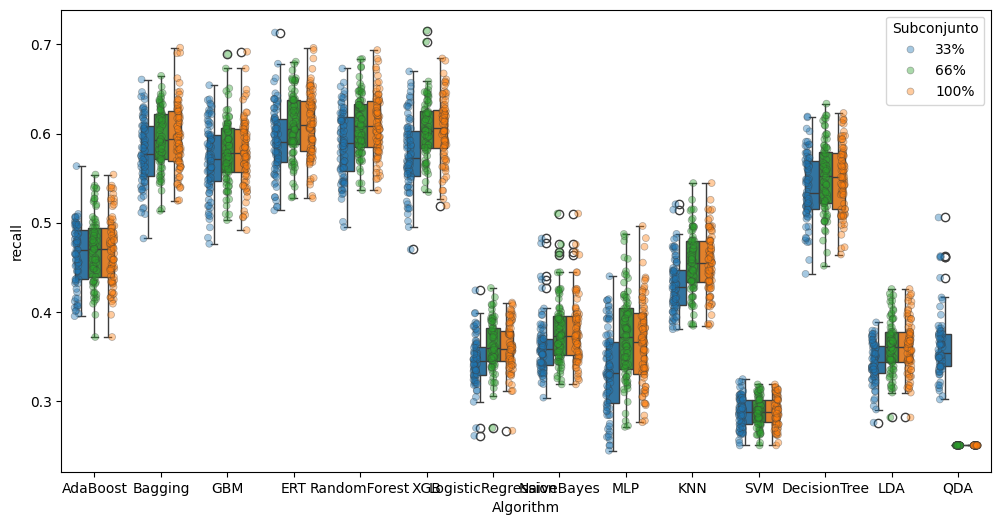

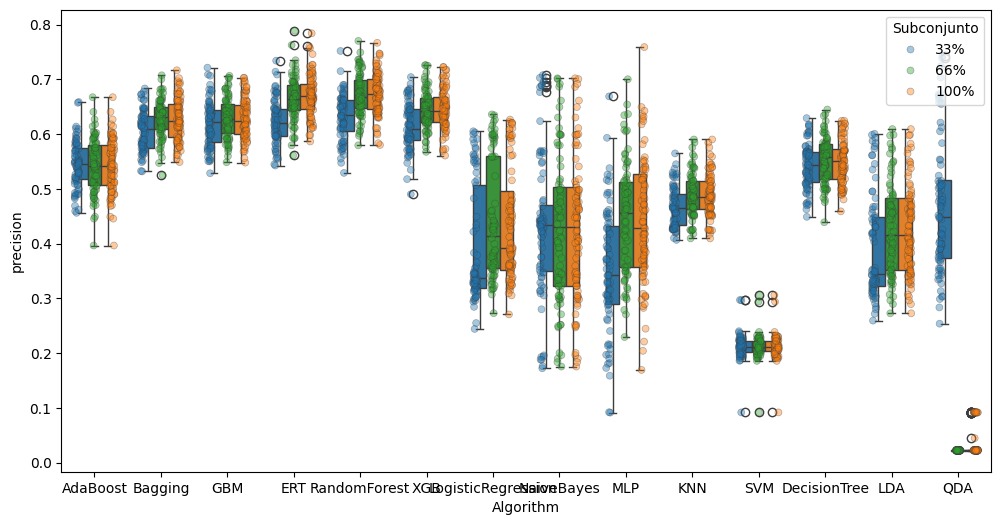

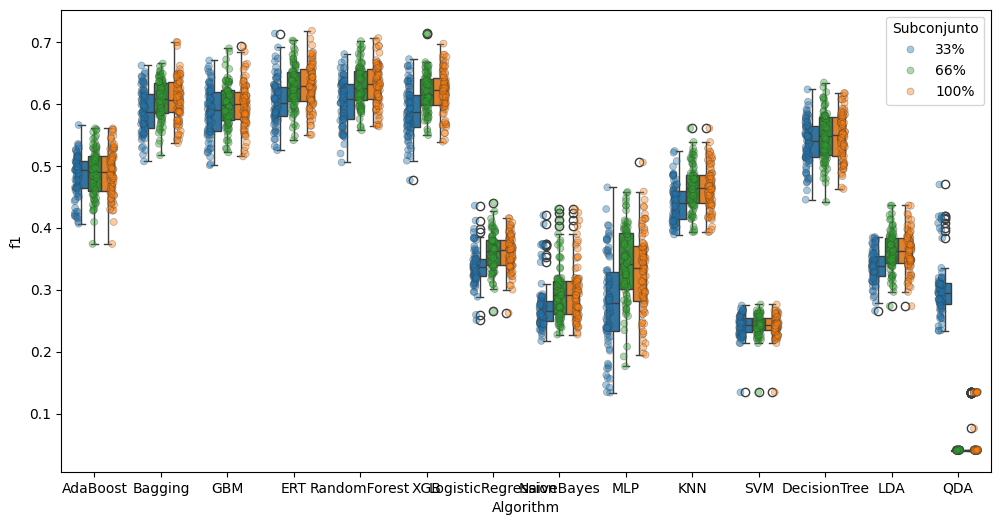

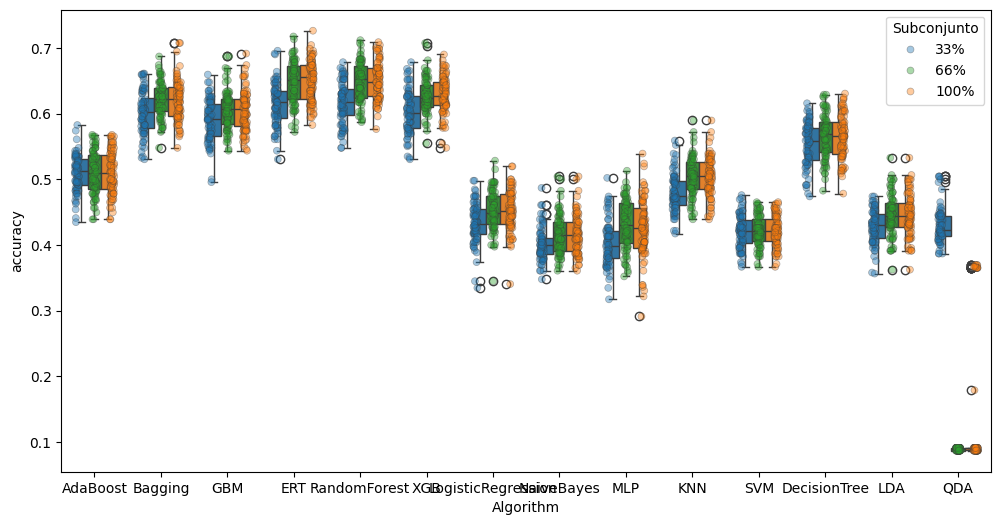

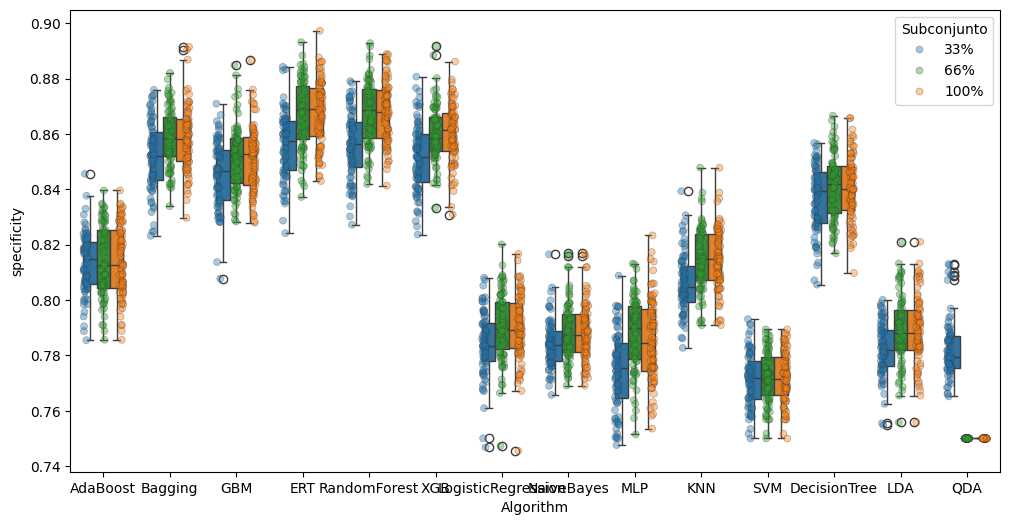

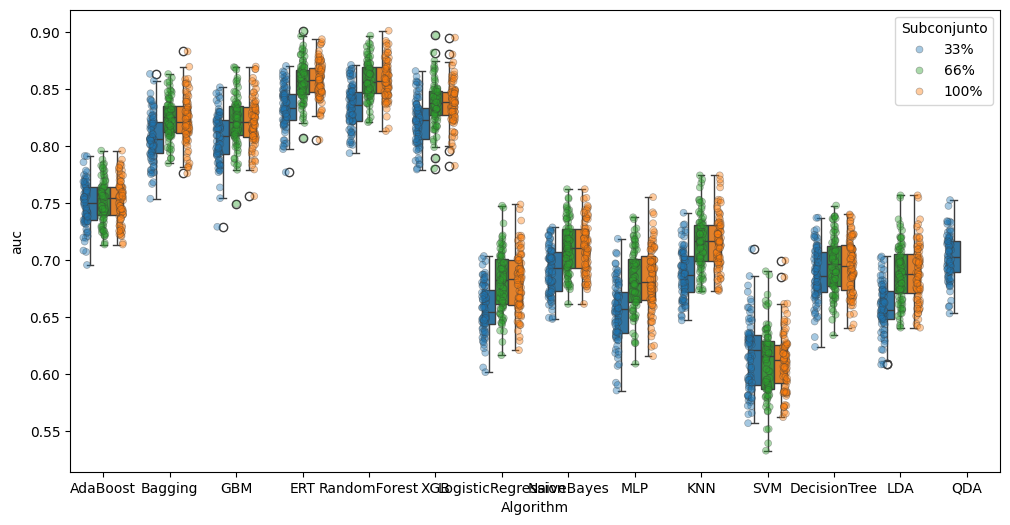

In [ ]:
# Paso 10: Evaluación con subconjuntos 33%, 66%, 100% basados en ranking

# Subconjuntos según ranking
top_5 = ranking_df.sort_values("Rank").head(5).index.tolist()
top_10 = ranking_df.sort_values("Rank").head(10).index.tolist()
all_features = df_encoded.columns.drop("target").tolist()

datasets = {
    '33%': df_encoded[top_5 + ['target']],
    '66%': df_encoded[top_10 + ['target']],
    '100%': df_encoded[all_features + ['target']]
}

# Colores para boxplot y stripplot
dataset_colors = {'33%': '#1f77b4', '66%': '#2ca02c', '100%': '#ff7f0e'}

results_all = []

for name, dataset in datasets.items():
    X = dataset.drop('target', axis=1).astype('float64')
    y = dataset['target']

    y_encoded = LabelEncoder().fit_transform(y)

    for model_label, model in models.items():
        print(f"Evaluando {model_label} con subconjunto {name}")
        df_metrics = repeated_cv_metrics(model, X, y_encoded, n_repeats=20, n_splits=4)
        df_metrics['Algorithm'] = model_label
        df_metrics['attr'] = name
        results_all.append(df_metrics)

# Consolidar resultados
df_results_all = pd.concat(results_all, ignore_index=True)

# Boxplots con stripplot superpuesto
for metric in ['recall', 'precision', 'f1', 'accuracy', 'specificity', 'auc']:
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(
        x='Algorithm',
        y=metric,
        hue='attr',
        data=df_results_all,
        palette=dataset_colors,
        dodge=True,
        width=0.6
    )
    sns.stripplot(
        x='Algorithm',
        y=metric,
        hue='attr',
        data=df_results_all,
        palette=dataset_colors,
        dodge=True,
        marker='o',
        edgecolor='gray',
        alpha=0.4,
        linewidth=0.5,
        ax=ax
    )

    # Leyenda sin duplicados
    handles, labels = ax.get_legend_handles_labels() 
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), title='Subconjunto', loc='upper right')

       


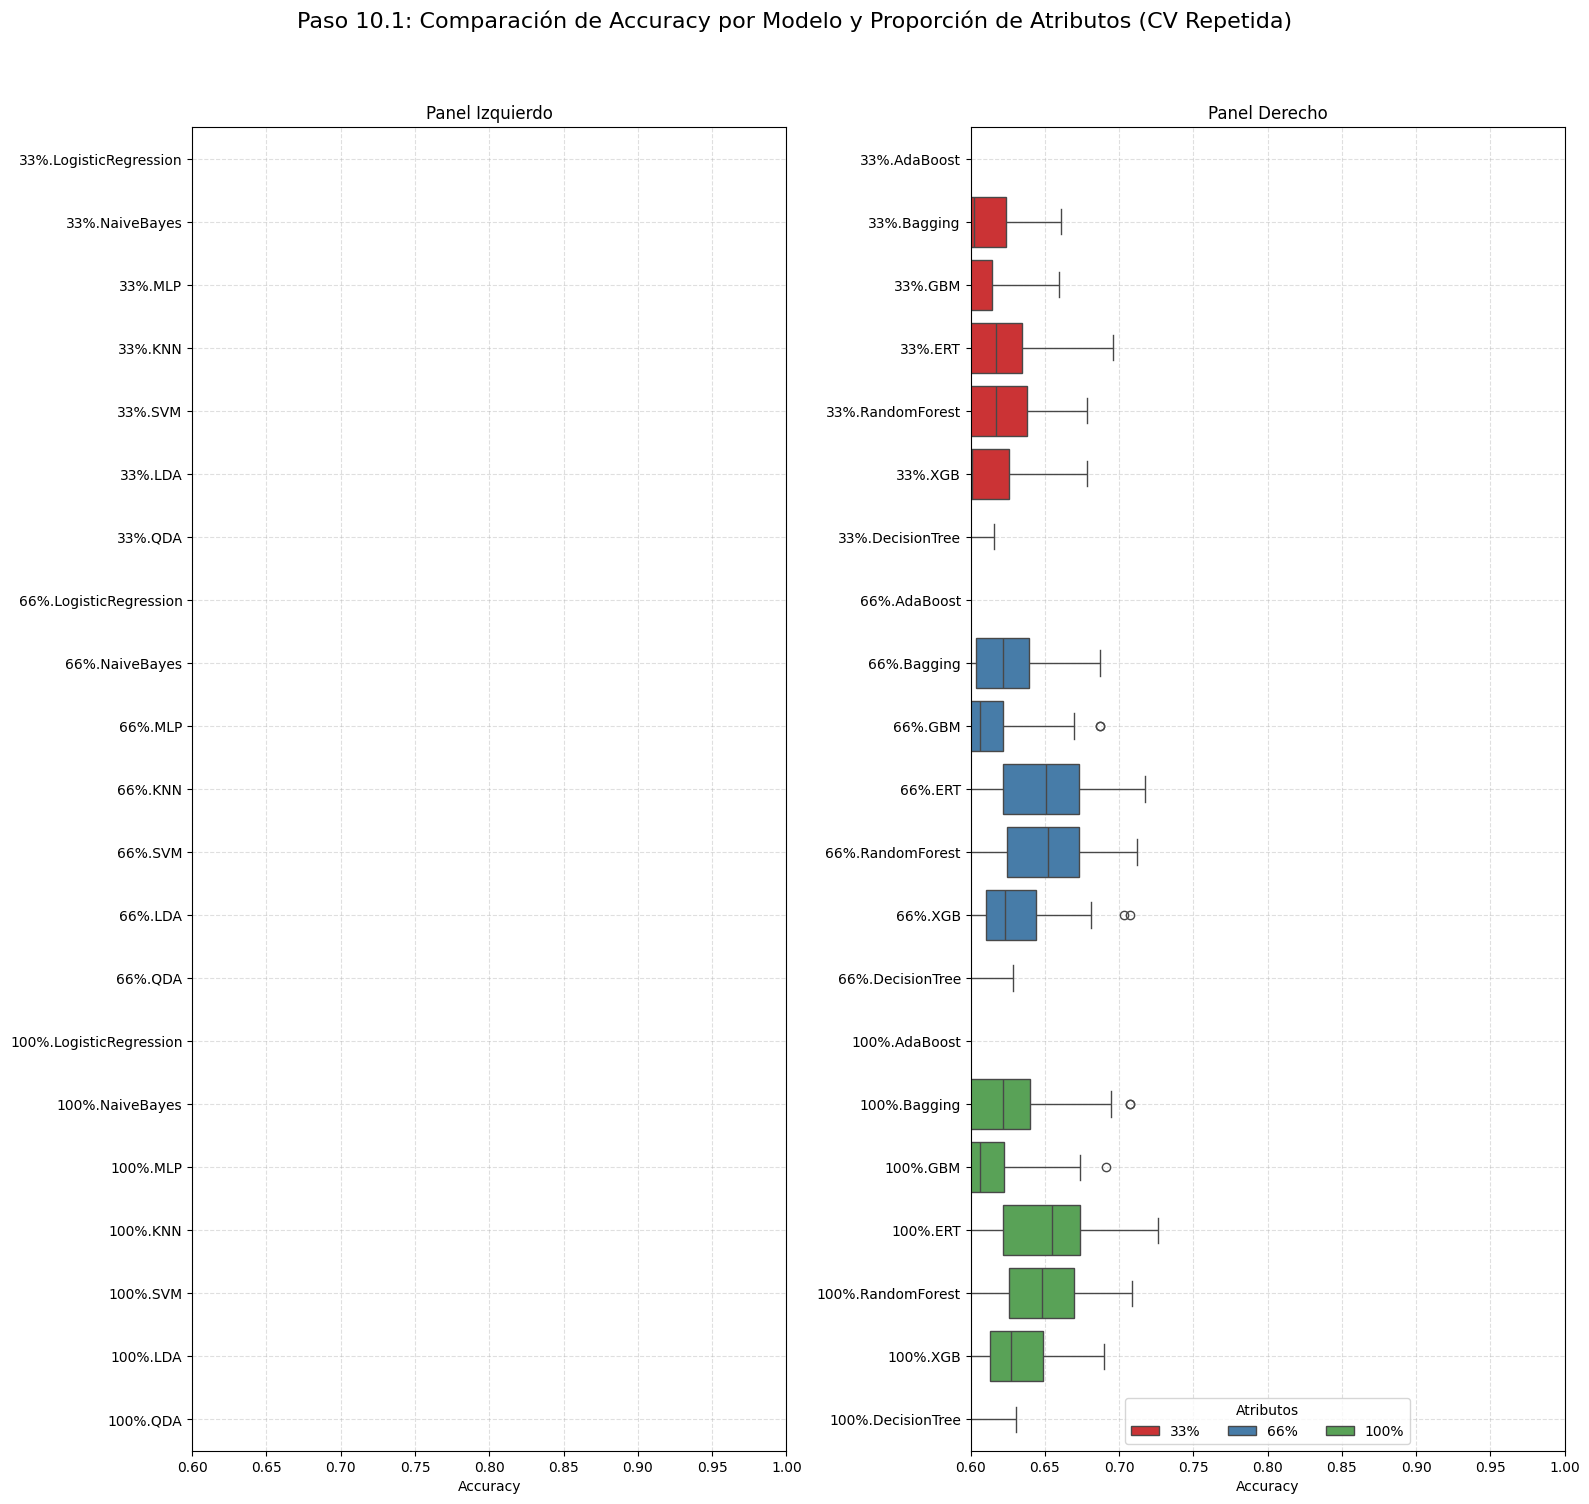

In [ ]:
 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# === Paso 10.1: Comparación de Accuracy por Modelo y Proporción de Atributos ===

# Crear etiquetas combinadas
df_results_all['Label'] = df_results_all['attr'] + '.' + df_results_all['Algorithm']

# Filtrar solo combinaciones válidas
valid_labels = df_results_all.groupby('Label')['accuracy'].apply(lambda x: x.notna().any())
df_results_all = df_results_all[df_results_all['Label'].isin(valid_labels[valid_labels].index)]

# Paleta por atributo (para hue)
attr_palette = {'33%': '#E41A1C', '66%': '#377EB8', '100%': '#4DAF4A'}

# Ordenar etiquetas por Accuracy promedio
sorted_labels = df_results_all.groupby('Label')['accuracy'].mean().sort_values().index.tolist()
half = len(sorted_labels) // 2 + len(sorted_labels) % 2
label_splits = [sorted_labels[:half], sorted_labels[half:]]

# Crear figura con dos paneles
fig = plt.figure(figsize=(16, len(sorted_labels) * 0.35))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
axs = [plt.subplot(gs[0]), plt.subplot(gs[1])]

for i, ax in enumerate(axs):
    labels = label_splits[i]
    subset = df_results_all[df_results_all['Label'].isin(labels)]

    sns.boxplot(
        data=subset,
        x='accuracy',
        y='Label',
        hue='attr',  # 🎯 diferenciación visual por subconjunto de atributos
        palette=attr_palette,
        orient='h',
        ax=ax
    )

    ax.set_xlim(0.6, 1.0)
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('')
    ax.set_title(f'Panel {"Izquierdo" if i == 0 else "Derecho"}')
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend_.remove()  # para que la leyenda se ponga al final

# Título general
plt.suptitle("Paso 10.1: Comparación de Accuracy por Modelo y Proporción de Atributos (CV Repetida)", fontsize=16, y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.legend(title='Atributos', loc='lower center', ncol=3)
plt.show()





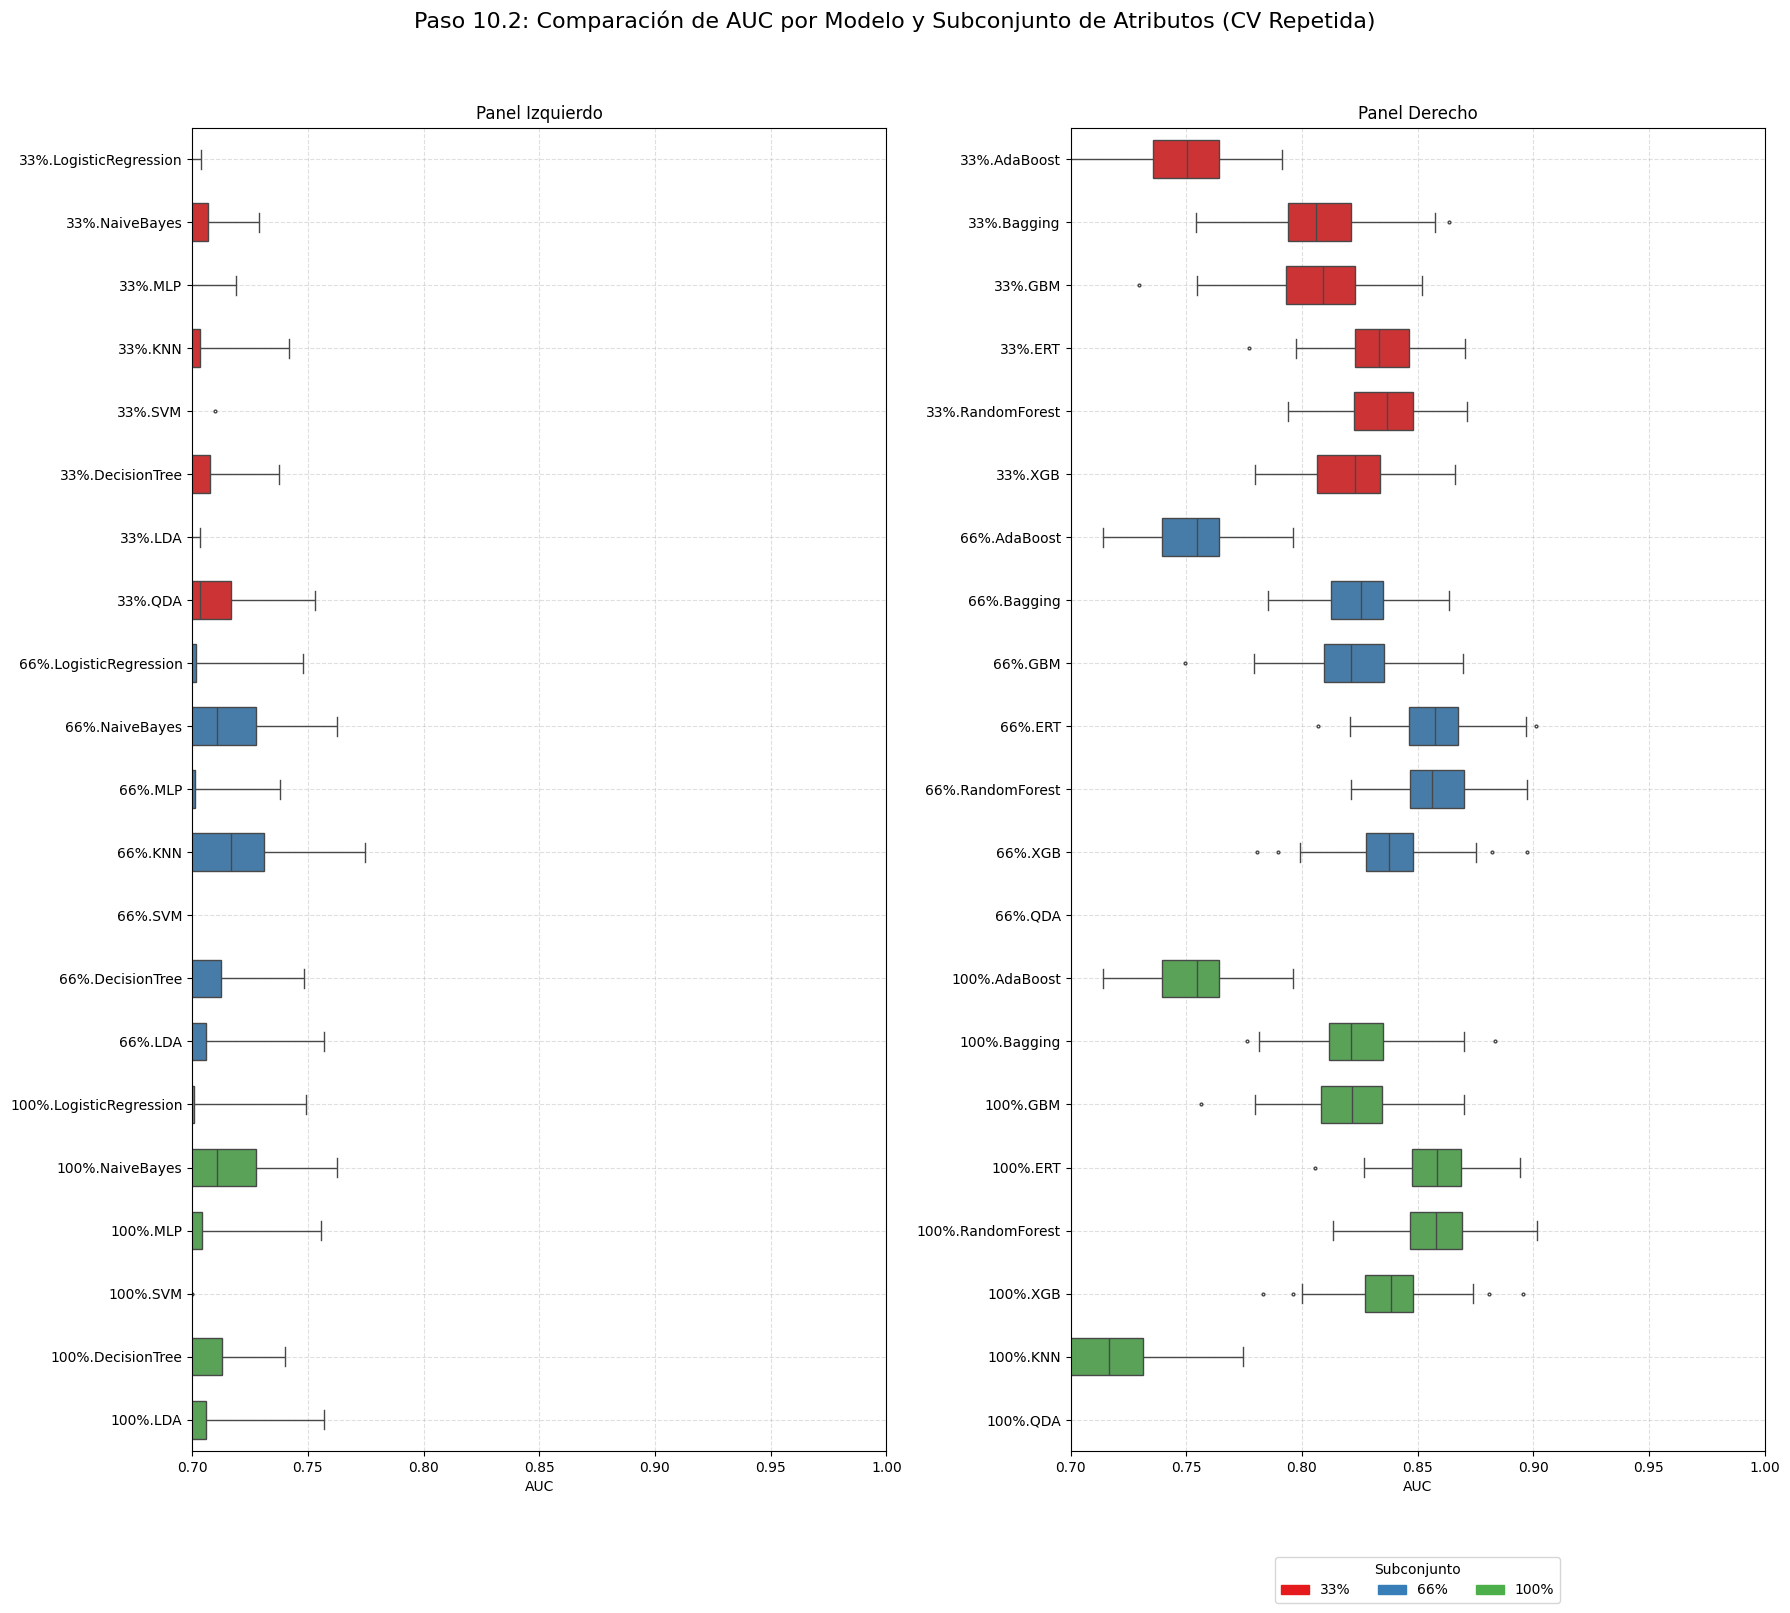

In [ ]:


import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch

# Normalizar nombres de columnas
df_results_all.columns = df_results_all.columns.str.lower()

# Validar columna AUC
if 'auc' not in df_results_all.columns:
    raise KeyError("La columna 'auc' no se encuentra en df_results_all. Verifica repeated_cv_metrics.")

# ✅ Asegurar que los valores en 'attr' estén con porcentaje (clave del error original)
df_results_all['attr'] = df_results_all['attr'].astype(str)
df_results_all['attr'] = df_results_all['attr'].replace({'33': '33%', '66': '66%', '100': '100%'})

# Crear etiquetas y colores
df_results_all['Label'] = df_results_all['attr'] + '.' + df_results_all['algorithm']
palette_custom = {'33%': '#E41A1C', '66%': '#377EB8', '100%': '#4DAF4A'}

# Ordenar combinaciones por promedio de AUC
sorted_labels = df_results_all.groupby('Label')['auc'].mean().sort_values().index.tolist()
half = len(sorted_labels) // 2
label_splits = [sorted_labels[:half], sorted_labels[half:]]

# Crear figura tipo panel
fig = plt.figure(figsize=(18, len(sorted_labels) * 0.35))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
axs = [plt.subplot(gs[0]), plt.subplot(gs[1])]

for i, ax in enumerate(axs):
    labels = label_splits[i]
    subset = df_results_all[df_results_all['Label'].isin(labels)]

    sns.boxplot(
        data=subset,
        x='auc',
        y='Label',
        hue='attr',
        palette=palette_custom,
        orient='h',
        ax=ax,
        width=0.6,
        fliersize=2
    )

    ax.set_xlim(0.7, 1.0)
    ax.set_xlabel('AUC')
    ax.set_ylabel('')
    ax.set_title(f'Panel {"Izquierdo" if i == 0 else "Derecho"}')
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend_.remove()

# Título y leyenda final
plt.suptitle("Paso 10.2: Comparación de AUC por Modelo y Subconjunto de Atributos (CV Repetida)", fontsize=16, y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.94)

# Leyenda unificada
legend_patches = [Patch(color=color, label=label) for label, color in palette_custom.items()]
plt.legend(handles=legend_patches, title='Subconjunto', loc='lower center', bbox_to_anchor=(0.5, -0.12), ncol=3)

plt.show()


Evaluando AdaBoost con subconjunto 33%
Evaluando Bagging con subconjunto 33%
Evaluando GBM con subconjunto 33%
Evaluando ERT con subconjunto 33%
Evaluando RandomForest con subconjunto 33%
Evaluando XGB con subconjunto 33%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:29:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:29:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:29:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:29:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

Evaluando LogisticRegression con subconjunto 33%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Evaluando NaiveBayes con subconjunto 33%
Evaluando MLP con subconjunto 33%
Evaluando KNN con subconjunto 33%
Evaluando SVM con subconjunto 33%
Evaluando DecisionTree con subconjunto 33%
Evaluando LDA con subconjunto 33%
Evaluando QDA con subconjunto 33%
Evaluando AdaBoost con subconjunto 66%
Evaluando Bagging con subconjunto 66%
Evaluando GBM con subconjunto 66%
Evaluando ERT con subconjunto 66%
Evaluando RandomForest con subconjunto 66%
Evaluando XGB con subconjunto 66%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:33:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:33:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:33:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:33:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

Evaluando LogisticRegression con subconjunto 66%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Evaluando NaiveBayes con subconjunto 66%
Evaluando MLP con subconjunto 66%
Evaluando KNN con subconjunto 66%
Evaluando SVM con subconjunto 66%
Evaluando DecisionTree con subconjunto 66%
Evaluando LDA con subconjunto 66%
Evaluando QDA con subconjunto 66%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is not full rank. Increasing the value of param

Evaluando AdaBoost con subconjunto 100%
Evaluando Bagging con subconjunto 100%
Evaluando GBM con subconjunto 100%
Evaluando ERT con subconjunto 100%
Evaluando RandomForest con subconjunto 100%
Evaluando XGB con subconjunto 100%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:36:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:36:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:36:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:36:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

Evaluando LogisticRegression con subconjunto 100%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Evaluando NaiveBayes con subconjunto 100%
Evaluando MLP con subconjunto 100%
Evaluando KNN con subconjunto 100%
Evaluando SVM con subconjunto 100%
Evaluando DecisionTree con subconjunto 100%
Evaluando LDA con subconjunto 100%
Evaluando QDA con subconjunto 100%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is not full rank. Increasing the value of param

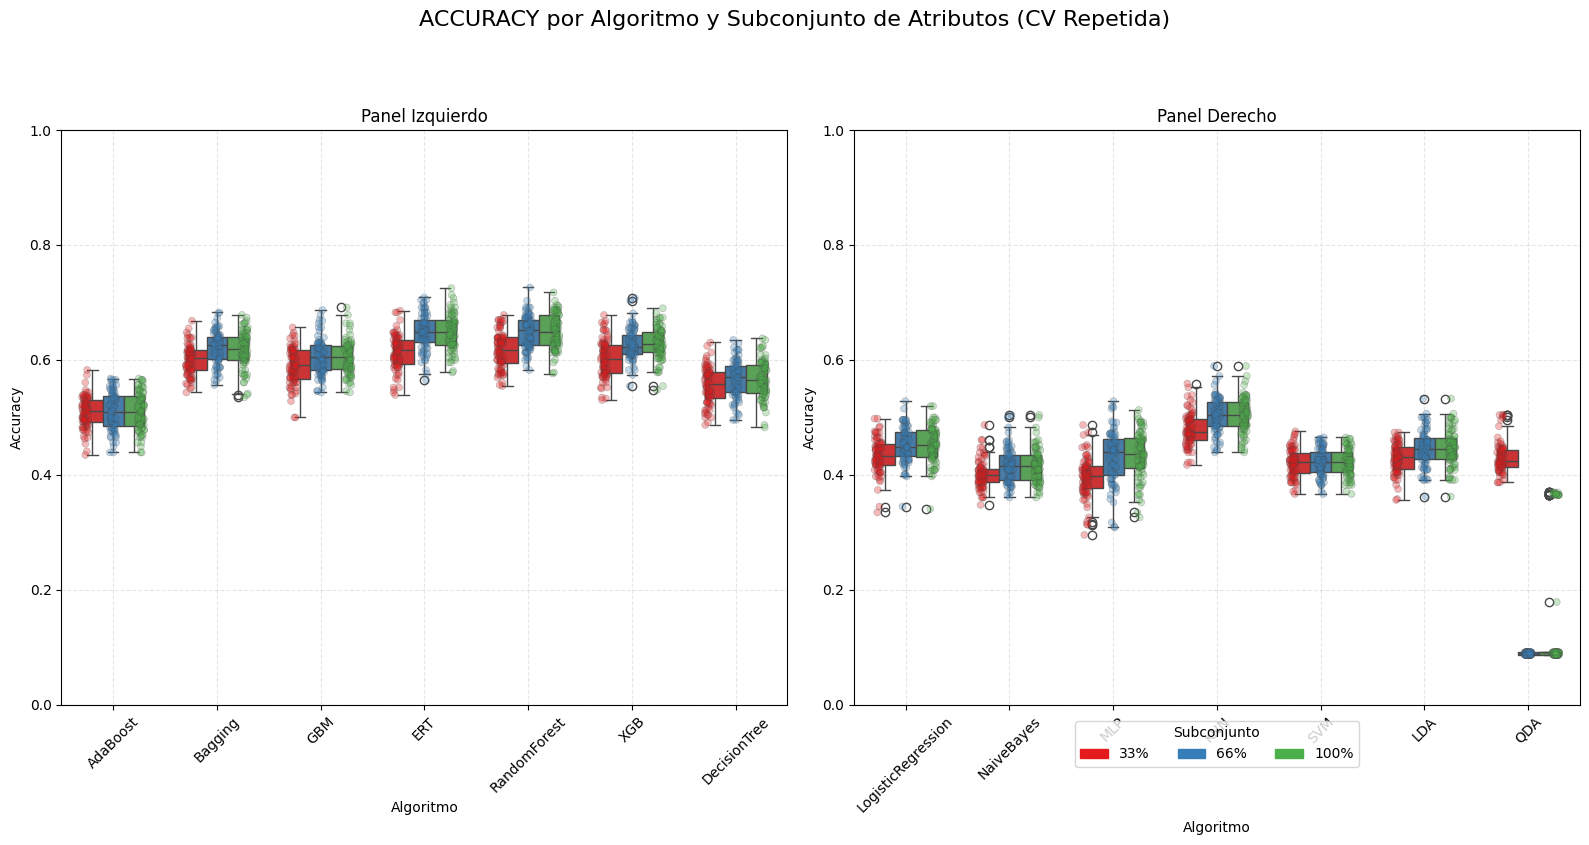

In [ ]:
# === Visualizaciones de Accuracy por tecnicas porcion de atributos ===

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import LabelEncoder

# Asegúrate de tener estas variables previamente definidas:
# df_encoded: tu dataset completo con variables codificadas + 'target'
# ranking_df: DataFrame con columnas 'Rank' y nombres de atributos
# models: diccionario con modelos scikit-learn
# repeated_cv_metrics: función que retorna un DataFrame con métricas

# === Paso 1: Construcción de subconjuntos según ranking ===
top_5 = ranking_df.sort_values("Rank").head(5).index.tolist()
top_10 = ranking_df.sort_values("Rank").head(10).index.tolist()
all_features = df_encoded.columns.drop("target").tolist()

datasets = {
    '33%': df_encoded[top_5 + ['target']],
    '66%': df_encoded[top_10 + ['target']],
    '100%': df_encoded[all_features + ['target']]
}

# === Paso 2: Evaluación de modelos ===
results_all = []

for name, dataset in datasets.items():
    X = dataset.drop('target', axis=1).astype('float64')
    y = dataset['target']
    y_encoded = LabelEncoder().fit_transform(y)

    for model_label, model in models.items():
        print(f"Evaluando {model_label} con subconjunto {name}")
        df_metrics = repeated_cv_metrics(model, X, y_encoded, n_repeats=20, n_splits=4)
        df_metrics['Algorithm'] = model_label
        df_metrics['attr'] = name
        results_all.append(df_metrics)

# === Paso 3: Consolidar resultados ===
df_results_all = pd.concat(results_all, ignore_index=True)

# === Paso 4: Visualización tipo boxplot vertical con panel izquierdo y derecho ===
# Filtrar atributos válidos
df_results_all = df_results_all[df_results_all['attr'].isin(['33%', '66%', '100%'])]

# Ordenar algoritmos por Accuracy promedio
mean_acc = df_results_all.groupby('Algorithm')['accuracy'].mean().sort_values(ascending=False)
sorted_algorithms = mean_acc.index.tolist()

# Dividir en dos paneles
half = len(sorted_algorithms) // 2 + len(sorted_algorithms) % 2
panel_splits = [sorted_algorithms[:half], sorted_algorithms[half:]]

# Paleta de colores por subconjunto
attr_palette = {'33%': '#E41A1C', '66%': '#377EB8', '100%': '#4DAF4A'}

# Crear figura
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
axs = [plt.subplot(gs[0]), plt.subplot(gs[1])]

for i, ax in enumerate(axs):
    algos = panel_splits[i]
    subset = df_results_all[df_results_all['Algorithm'].isin(algos)]

    sns.boxplot(
        data=subset,
        x='Algorithm',
        y='accuracy',
        hue='attr',
        palette=attr_palette,
        ax=ax,
        dodge=True,
        width=0.6
    )

    sns.stripplot(
        data=subset,
        x='Algorithm',
        y='accuracy',
        hue='attr',
        palette=attr_palette,
        dodge=True,
        marker='o',
        edgecolor='gray',
        alpha=0.3,
        linewidth=0.5,
        ax=ax
    )

    ax.set_title(f'Panel {"Izquierdo" if i == 0 else "Derecho"}')
    ax.set_xlabel('Algoritmo')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0.0, 1.0)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend_.remove()

# Título y leyenda final
plt.suptitle('ACCURACY por Algoritmo y Subconjunto de Atributos (CV Repetida)', fontsize=16, y=1.05)
plt.tight_layout()
plt.subplots_adjust(top=0.90)

# Agregar leyenda general abajo
from matplotlib.patches import Patch
legend_patches = [Patch(color=color, label=label) for label, color in attr_palette.items()]
plt.legend(handles=legend_patches, title='Subconjunto', loc='lower center', bbox_to_anchor=(0.5, -0.12), ncol=3)

plt.show()




Evaluando AdaBoost con subconjunto 33%
Evaluando Bagging con subconjunto 33%
Evaluando GBM con subconjunto 33%
Evaluando ERT con subconjunto 33%
Evaluando RandomForest con subconjunto 33%
Evaluando XGB con subconjunto 33%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:54:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:54:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:54:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:54:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

Evaluando LogisticRegression con subconjunto 33%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Evaluando NaiveBayes con subconjunto 33%
Evaluando MLP con subconjunto 33%
Evaluando KNN con subconjunto 33%
Evaluando SVM con subconjunto 33%
Evaluando DecisionTree con subconjunto 33%
Evaluando LDA con subconjunto 33%
Evaluando QDA con subconjunto 33%
Evaluando AdaBoost con subconjunto 66%
Evaluando Bagging con subconjunto 66%
Evaluando GBM con subconjunto 66%
Evaluando ERT con subconjunto 66%
Evaluando RandomForest con subconjunto 66%
Evaluando XGB con subconjunto 66%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:58:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:58:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:58:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:58:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

Evaluando LogisticRegression con subconjunto 66%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Evaluando NaiveBayes con subconjunto 66%
Evaluando MLP con subconjunto 66%
Evaluando KNN con subconjunto 66%
Evaluando SVM con subconjunto 66%
Evaluando DecisionTree con subconjunto 66%
Evaluando LDA con subconjunto 66%
Evaluando QDA con subconjunto 66%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is not full rank. Increasing the value of param

Evaluando AdaBoost con subconjunto 100%
Evaluando Bagging con subconjunto 100%
Evaluando GBM con subconjunto 100%
Evaluando ERT con subconjunto 100%
Evaluando RandomForest con subconjunto 100%
Evaluando XGB con subconjunto 100%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [09:02:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [09:02:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [09:02:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [09:02:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

Evaluando LogisticRegression con subconjunto 100%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Evaluando NaiveBayes con subconjunto 100%
Evaluando MLP con subconjunto 100%
Evaluando KNN con subconjunto 100%
Evaluando SVM con subconjunto 100%
Evaluando DecisionTree con subconjunto 100%
Evaluando LDA con subconjunto 100%
Evaluando QDA con subconjunto 100%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is not full rank. Increasing the value of param

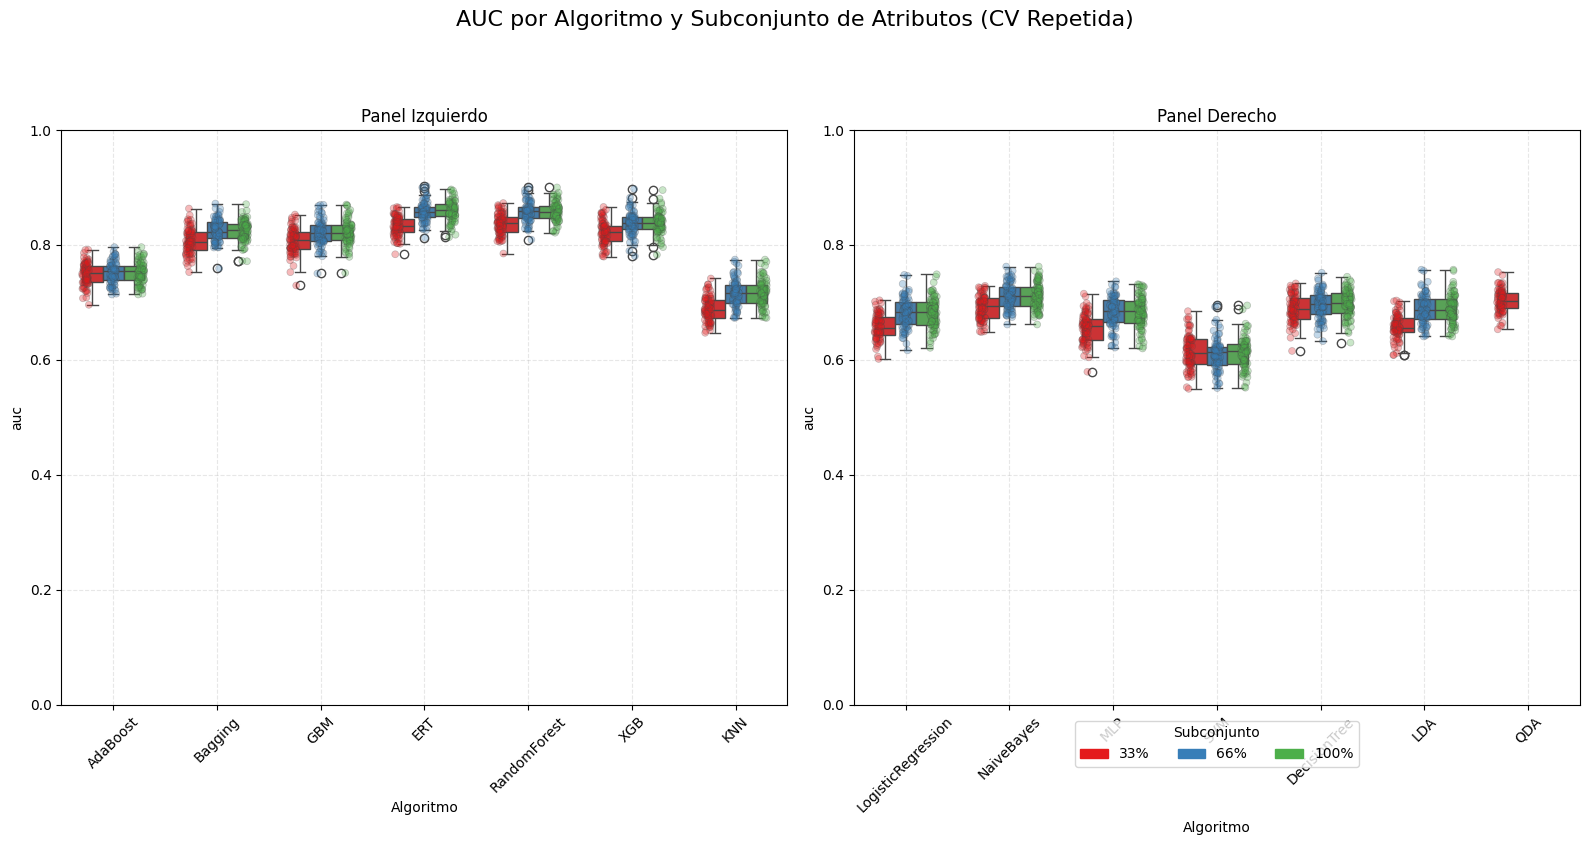

In [ ]:
# === Visualizaciones de Accuracy por tecnicas porcion de atributos ===

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import LabelEncoder

# Asegúrate de tener estas variables previamente definidas:
# df_encoded: tu dataset completo con variables codificadas + 'target'
# ranking_df: DataFrame con columnas 'Rank' y nombres de atributos
# models: diccionario con modelos scikit-learn
# repeated_cv_metrics: función que retorna un DataFrame con métricas

# === Paso 1: Construcción de subconjuntos según ranking ===
top_5 = ranking_df.sort_values("Rank").head(5).index.tolist()
top_10 = ranking_df.sort_values("Rank").head(10).index.tolist()
all_features = df_encoded.columns.drop("target").tolist()

datasets = {
    '33%': df_encoded[top_5 + ['target']],
    '66%': df_encoded[top_10 + ['target']],
    '100%': df_encoded[all_features + ['target']]
}

# === Paso 2: Evaluación de modelos ===
results_all = []

for name, dataset in datasets.items():
    X = dataset.drop('target', axis=1).astype('float64')
    y = dataset['target']
    y_encoded = LabelEncoder().fit_transform(y)

    for model_label, model in models.items():
        print(f"Evaluando {model_label} con subconjunto {name}")
        df_metrics = repeated_cv_metrics(model, X, y_encoded, n_repeats=20, n_splits=4)
        df_metrics['Algorithm'] = model_label
        df_metrics['attr'] = name
        results_all.append(df_metrics)

# === Paso 3: Consolidar resultados ===
df_results_all = pd.concat(results_all, ignore_index=True)

# === Paso 4: Visualización tipo boxplot vertical con panel izquierdo y derecho ===
# Filtrar atributos válidos
df_results_all = df_results_all[df_results_all['attr'].isin(['33%', '66%', '100%'])]

# Ordenar algoritmos por Accuracy promedio
mean_acc = df_results_all.groupby('Algorithm')['auc'].mean().sort_values(ascending=False)
sorted_algorithms = mean_acc.index.tolist()

# Dividir en dos paneles
half = len(sorted_algorithms) // 2 + len(sorted_algorithms) % 2
panel_splits = [sorted_algorithms[:half], sorted_algorithms[half:]]

# Paleta de colores por subconjunto
attr_palette = {'33%': '#E41A1C', '66%': '#377EB8', '100%': '#4DAF4A'}

# Crear figura
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
axs = [plt.subplot(gs[0]), plt.subplot(gs[1])]

for i, ax in enumerate(axs):
    algos = panel_splits[i]
    subset = df_results_all[df_results_all['Algorithm'].isin(algos)]

    sns.boxplot(
        data=subset,
        x='Algorithm',
        y='auc',
        hue='attr',
        palette=attr_palette,
        ax=ax,
        dodge=True,
        width=0.6
    )

    sns.stripplot(
        data=subset,
        x='Algorithm',
        y='auc',
        hue='attr',
        palette=attr_palette,
        dodge=True,
        marker='o',
        edgecolor='gray',
        alpha=0.3,
        linewidth=0.5,
        ax=ax
    )

    ax.set_title(f'Panel {"Izquierdo" if i == 0 else "Derecho"}')
    ax.set_xlabel('Algoritmo')
    ax.set_ylabel('auc')
    ax.set_ylim(0.0, 1.0)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend_.remove()

# Título y leyenda final
plt.suptitle('AUC por Algoritmo y Subconjunto de Atributos (CV Repetida)', fontsize=16, y=1.05)
plt.tight_layout()
plt.subplots_adjust(top=0.90)

# Agregar leyenda general abajo
from matplotlib.patches import Patch
legend_patches = [Patch(color=color, label=label) for label, color in attr_palette.items()]
plt.legend(handles=legend_patches, title='Subconjunto', loc='lower center', bbox_to_anchor=(0.5, -0.12), ncol=3)

plt.show()

In [ ]:
'''
#Visualizaciones de AUC por tecnicas y porcentaje de atributos

# Gráfico tipo panel para AUC tipo boxplot de los diferentes conjuntos de datos 
import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib.pyplot as plt

# Asegurarse de que estas columnas estén generadas
df_vis = X.copy()
df_vis['target'] = y

subset_33 = X.columns[:max(1, len(X.columns)//3)].tolist()
subset_66 = X.columns[:max(1, 2*len(X.columns)//3)].tolist()
subset_100 = X.columns.tolist()

datasets = {
    '33': df_vis[subset_33 + ['target']],
    '66': df_vis[subset_66 + ['target']],
    '100': df_vis[subset_100 + ['target']]
}

results_all = []

for name, dataset in datasets.items():
    X_ds = dataset.drop('target', axis=1)
    y_ds = dataset['target']

    X_train, X_valid, y_train, y_valid = train_test_split(X_ds, y_ds, test_size=0.25, random_state=42, stratify=y_ds)

    X_train_np = np.ascontiguousarray(X_train.values)
    X_valid_np = np.ascontiguousarray(X_valid.values)

    for model_label, model in models.items():
        model.fit(X_train_np, y_train)
        result = metricas(model, model_label, X_train_np, X_valid_np, y_train, y_valid)
        result['attr'] = name
        result['Algorithm'] = model_label
        results_all.append(result)

# Crear DataFrame consolidado
df_results_all = pd.DataFrame(results_all)
df_results_all['Label'] = df_results_all['attr'] + '.' + df_results_all['Algorithm']
df_results_all['Color'] = df_results_all['attr'].map({'33': 'red', '66': 'green', '100': 'blue'})

# Crear gráfico alternativo usando stripplot para asegurar visualización correcta

plt.figure(figsize=(10, 12))
sns.stripplot(
    data=df_results_all,
    y='Label',
    x='Accuracy',
    hue='attr',
    palette={'33': '#1f77b4', '66': '#2ca02c', '100': '#ff7f0e'},
    dodge=True,
    alpha=0.8
)
plt.title("Accuracy por modelo y subconjunto")
plt.xlabel("Accuracy")
plt.ylabel("")
plt.legend(title='Subconjunto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Gráfico tipo panel para AUC por modelo y subconjunto (usando stripplot)
metric = 'AUC'
sorted_labels_auc = df_results_all.groupby('Label')[metric].mean().sort_values().index

plt.figure(figsize=(10, 12))
sns.stripplot(
    data=df_results_all[df_results_all['Label'].isin(sorted_labels_auc)],
    y='Label',
    x=metric,
    hue='attr',
    palette={'33': '#1f77b4', '66': '#2ca02c', '100': '#ff7f0e'},
    dodge=True,
    alpha=0.8
)
plt.title("AUC por modelo y subconjunto")
plt.xlabel("AUC")   
plt.ylabel("")
plt.legend(title='Subconjunto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

'''

'\n#Visualizaciones de AUC por tecnicas y porcentaje de atributos\n\n# Gráfico tipo panel para AUC tipo boxplot de los diferentes conjuntos de datos \nimport matplotlib.gridspec as gridspec\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Asegurarse de que estas columnas estén generadas\ndf_vis = X.copy()\ndf_vis[\'target\'] = y\n\nsubset_33 = X.columns[:max(1, len(X.columns)//3)].tolist()\nsubset_66 = X.columns[:max(1, 2*len(X.columns)//3)].tolist()\nsubset_100 = X.columns.tolist()\n\ndatasets = {\n    \'33\': df_vis[subset_33 + [\'target\']],\n    \'66\': df_vis[subset_66 + [\'target\']],\n    \'100\': df_vis[subset_100 + [\'target\']]\n}\n\nresults_all = []\n\nfor name, dataset in datasets.items():\n    X_ds = dataset.drop(\'target\', axis=1)\n    y_ds = dataset[\'target\']\n\n    X_train, X_valid, y_train, y_valid = train_test_split(X_ds, y_ds, test_size=0.25, random_state=42, stratify=y_ds)\n\n    X_train_np = np.ascontiguousarray(X_train.values)\n    X_valid_np = np.a

In [ ]:


# Análisis de Curvas de Rashomon con Múltiples Conjuntos de Atributos

import time
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import pandas as pd

warnings.filterwarnings('ignore')

# Supuestos: variables disponibles
# X, y, ranking_df, models

# Definición de subconjuntos de atributos
total_features = len(ranking_df)
feature_sets = {
    'top33': ranking_df.sort_values("Rank").head(round(0.33 * total_features)).index.tolist(),
    'top66': ranking_df.sort_values("Rank").head(round(0.66 * total_features)).index.tolist(),
    'top100': ranking_df.sort_values("Rank").index.tolist()
}

rashomon_results = []
epsilon = 0.01  # 1% del mejor AUC

for subset_name, features in feature_sets.items():
    X_sub = X[features]
    X_train_r, X_valid_r, y_train_r, y_valid_r = train_test_split(X_sub, y, test_size=0.25, random_state=42)

    subset_scores = []
    best_auc = 0

    for model_label, model in models.items():
        try:
            start = time.time()
            model.fit(X_train_r, y_train_r)
            train_time = time.time() - start

            y_pred = model.predict(X_valid_r)
            try:
                y_prob = model.predict_proba(X_valid_r)
                if y_prob.shape[1] > 1:
                    from sklearn.preprocessing import label_binarize
                    y_bin = label_binarize(y_valid_r, classes=list(range(y_prob.shape[1])))
                    auc = roc_auc_score(y_bin, y_prob, average='macro')
                else:
                    auc = roc_auc_score(y_valid_r, y_prob[:, 0])
            except:
                auc = roc_auc_score(y_valid_r, y_pred)

            best_auc = max(best_auc, auc)

            if hasattr(model, 'n_estimators'):
                complexity = model.n_estimators
            elif hasattr(model, 'coef_'):
                complexity = model.coef_.shape[1]
            elif hasattr(model, 'hidden_layer_sizes'):
                complexity = sum(model.hidden_layer_sizes)
            elif hasattr(model, 'tree_'):
                complexity = model.tree_.max_depth
            elif hasattr(model, 'estimators_'):
                complexity = sum([est.tree_.node_count for est in model.estimators_])
            else:
                complexity = train_time

            subset_scores.append({
                'Subset': subset_name,
                'Model': model_label,
                'AUC': auc,
                'TrainingTime': train_time,
                'Complexity': complexity
            })
        except Exception as e:
            print(f'Error with {model_label} on {subset_name}:', e)

    rashomon_models = [s for s in subset_scores if s['AUC'] >= (best_auc - epsilon)]
    rashomon_volume = len(rashomon_models)

    for score in subset_scores:
        score['BestAUC'] = best_auc
        score['RashomonVolume'] = rashomon_volume
        score['WithinEpsilon'] = score['AUC'] >= (best_auc - epsilon)

    rashomon_results.extend(subset_scores)

rashomon_df = pd.DataFrame(rashomon_results)
rashomon_df

Error with QDA on top100: multi_class must be in ('ovo', 'ovr')


Subset               Model       AUC  TrainingTime  Complexity   BestAUC  \
0    top33            AdaBoost  0.766009      0.134726   50.000000  0.803136   
1    top33             Bagging  0.779773      0.049789   10.000000  0.803136   
2    top33                 GBM  0.792317      0.883030  100.000000  0.803136   
3    top33                 ERT  0.774472      0.303631  100.000000  0.803136   
4    top33        RandomForest  0.803136      0.243071  100.000000  0.803136   
5    top33                 XGB  0.776826      0.327414         NaN  0.803136   
6    top33  LogisticRegression  0.660161      0.356806    3.000000  0.803136   
7    top33          NaiveBayes  0.667258      0.003234    0.003234  0.803136   
8    top33                 MLP  0.639931      0.117815  100.000000  0.803136   
9    top33                 KNN  0.780397      0.002120    0.002120  0.803136   
10   top33                 SVM  0.621388      0.100198    0.100198  0.803136   
11   top33        DecisionTree  0.678726      0.004452   16.000000  0.803136   
12   top33                 LDA  0.653883      0.004155    3.000000  0.803136   
13   top33                 QDA  0.691435      0.003115    0.003115  0.803136   
14   top66            AdaBoost  0.773720      0.122755   50.000000  0.848684   
15   top66             Bagging  0.841110      0.056112   10.000000  0.848684   
16   top66                 GBM  0.786064      0.975698  100.000000  0.848684   
17   top66                 ERT  0.844298      0.183897  100.000000  0.848684   
18   top66        RandomForest  0.848684      0.283430  100.000000  0.848684   
19   top66                 XGB  0.819404      0.308501         NaN  0.848684   
20   top66  LogisticRegression  0.677525      0.353036    5.000000  0.848684   
21   top66          NaiveBayes  0.700981      0.002017    0.002017  0.848684   
22   top66                 MLP  0.686092      0.088076  100.000000  0.848684   
23   top66                 KNN  0.780867      0.002567    0.002567  0.848684   
24   top66                 SVM  0.641493      0.105262    0.105262  0.848684   
25   top66        DecisionTree  0.693081      0.006513   14.000000  0.848684   
26   top66                 LDA  0.672910      0.003502    5.000000  0.848684   
27   top66                 QDA  0.703370      0.002023    0.002023  0.848684   
28  top100            AdaBoost  0.780895      0.143402   50.000000  0.871382   
29  top100             Bagging  0.825075      0.062818   10.000000  0.871382   
30  top100                 GBM  0.823835      1.211967  100.000000  0.871382   
31  top100                 ERT  0.871382      0.177663  100.000000  0.871382   
32  top100        RandomForest  0.869947      0.299476  100.000000  0.871382   
33  top100                 XGB  0.841852      0.352698         NaN  0.871382   
34  top100  LogisticRegression  0.692671      0.375345    8.000000  0.871382   
35  top100          NaiveBayes  0.721909      0.001287    0.001287  0.871382   
36  top100                 MLP  0.709235      0.097887  100.000000  0.871382   
37  top100                 KNN  0.707186      0.002143    0.002143  0.871382   
38  top100                 SVM  0.587305      0.116663    0.116663  0.871382   
39  top100        DecisionTree  0.687694      0.008696   15.000000  0.871382   
40  top100                 LDA  0.680922      0.002004    8.000000  0.871382   

    RashomonVolume  WithinEpsilon  
0                1          False  
1                1          False  
2                1          False  
3                1          False  
4                1           True  
5                1          False  
6                1          False  
7                1          False  
8                1          False  
9                1          False  
10               1          False  
11               1          False  
12               1          False  
13               1          False  
14               3          False  
15               3           True  
16               3          Fal

In [ ]:
# Identificar modelos en el frente de Pareto (AUC vs. Complejidad)

def is_pareto_efficient(df, perf_col="AUC", cost_col="Complexity"):
    is_efficient = []
    for i, row_i in df.iterrows():
        dominated = False
        for j, row_j in df.iterrows():
            if (
                (row_j[perf_col] >= row_i[perf_col])
                and (row_j[cost_col] <= row_i[cost_col])
                and ((row_j[perf_col] > row_i[perf_col]) or (row_j[cost_col] < row_i[cost_col]))
            ):
                dominated = True
                break
        is_efficient.append(not dominated)
    return is_efficient

# Aplicar por subconjunto
pareto_df_list = []
for subset in rashomon_df['Subset'].unique():
    df_subset = rashomon_df[rashomon_df['Subset'] == subset].copy()
    df_subset['ParetoFront'] = is_pareto_efficient(df_subset)
    pareto_df_list.append(df_subset)

pareto_df = pd.concat(pareto_df_list)

# Exportar modelos en el frente de Pareto
pareto_df[pareto_df['ParetoFront']].to_csv("rashomon_pareto_models.csv", index=False)
print("Modelos en el frente de Pareto exportados como 'rashomon_pareto_models.csv'")
pareto_df[pareto_df['ParetoFront']]

Modelos en el frente de Pareto exportados como 'rashomon_pareto_models.csv'


Subset         Model       AUC  TrainingTime  Complexity   BestAUC  \
1    top33       Bagging  0.784576      0.031848   10.000000  0.799037   
4    top33  RandomForest  0.799037      0.231495  100.000000  0.799037   
5    top33           XGB  0.776826      0.233644         NaN  0.799037   
9    top33           KNN  0.780397      0.016143    0.016143  0.799037   
13   top33           QDA  0.691435      0.000000    0.000000  0.799037   
15   top66       Bagging  0.800905      0.047514   10.000000  0.854897   
18   top66  RandomForest  0.854897      0.269667  100.000000  0.854897   
19   top66           XGB  0.819404      0.320904         NaN  0.854897   
23   top66           KNN  0.780867      0.000000    0.000000  0.854897   
29  top100       Bagging  0.826688      0.063076   10.000000  0.872162   
32  top100  RandomForest  0.872162      0.255504  100.000000  0.872162   
33  top100           XGB  0.841852      0.280030         NaN  0.872162   
35  top100    NaiveBayes  0.721909      0.000000    0.000000  0.872162   

    RashomonVolume  WithinEpsilon  ParetoFront  
1                2          False         True  
4                2           True         True  
5                2          False         True  
9                2          False         True  
13               2          False         True  
15               2          False         True  
18               2           True         True  
19               2          False         True  
23               2          False         True  
29               2          False         True  
32               2           True         True  
33               2          False         True  
35               2          False         True

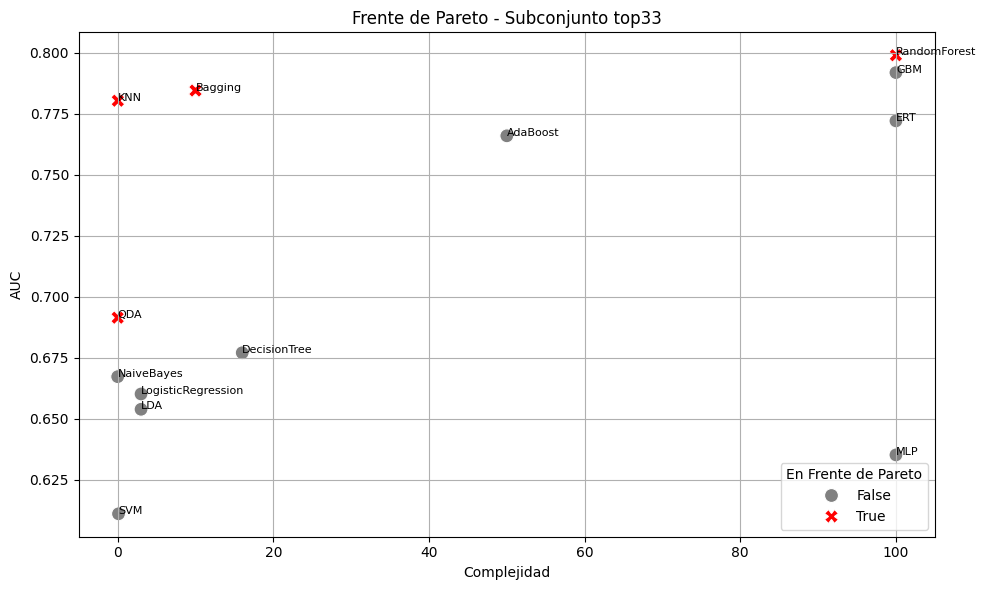

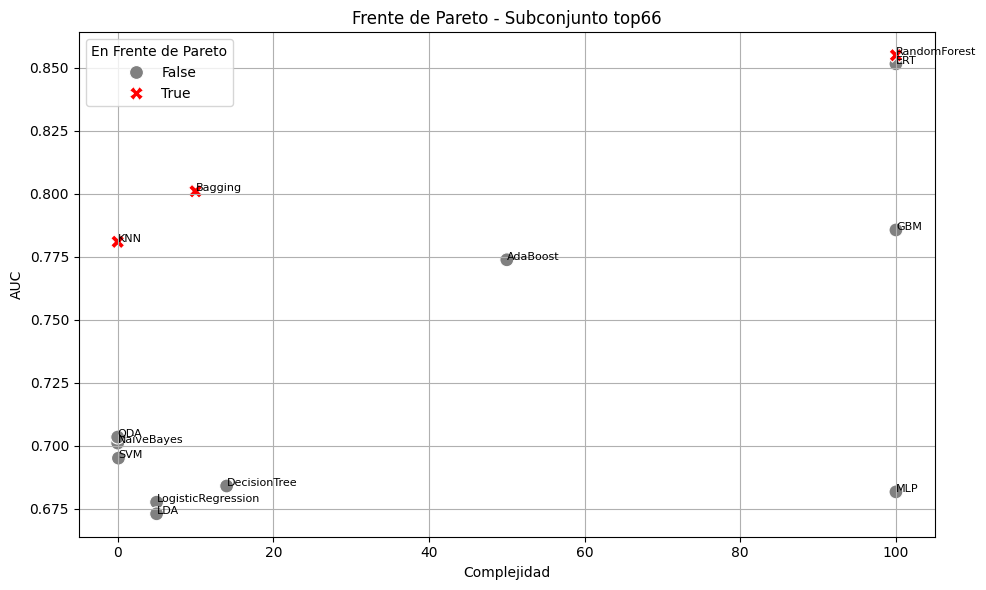

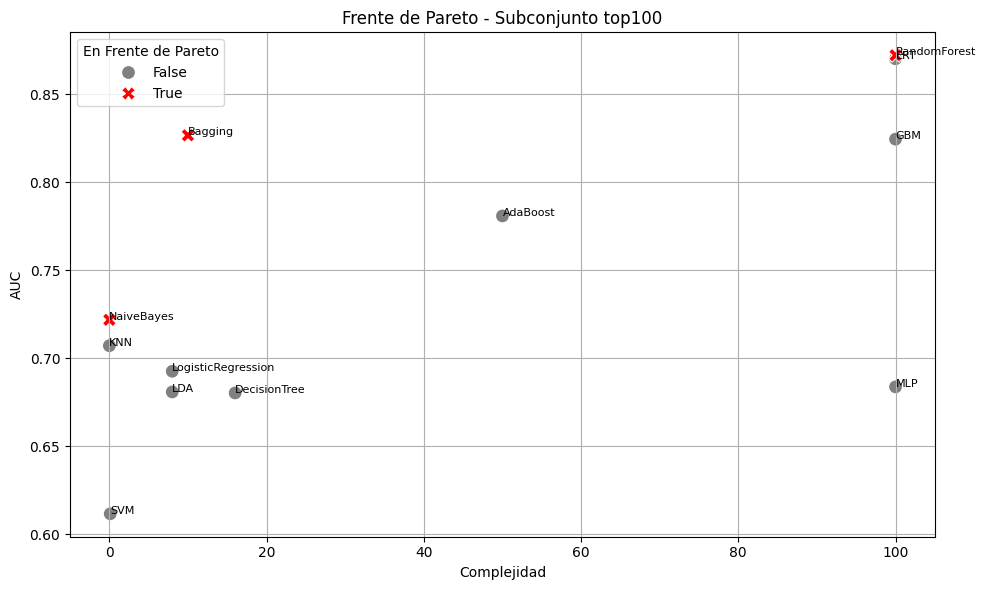

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualización del frente de Pareto para cada subconjunto
for subset in pareto_df['Subset'].unique():
    data = pareto_df[pareto_df['Subset'] == subset]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='Complexity', y='AUC',
        hue='ParetoFront',
        style='ParetoFront',
        palette={True: 'red', False: 'gray'},
        data=data,
        s=100
    )
    for _, row in data.iterrows():
        plt.text(row['Complexity'], row['AUC'], row['Model'], fontsize=8)

    plt.title(f'Frente de Pareto - Subconjunto {subset}')
    plt.xlabel('Complejidad')
    plt.ylabel('AUC')
    plt.legend(title='En Frente de Pareto')
    plt.grid(True)
    plt.tight_layout()
    plt.show()